# Amazon Nova Models: Real-World Reasoning Evaluation

## Overview

This notebook provides a comprehensive, quantitative evaluation of **Amazon Nova Lite v2.0** alongside other **Amazon Nova foundation models** on real-world customer support reasoning tasks. We compare five Nova models across multiple dimensions to understand their capabilities in handling complex, nuanced customer service scenarios that require empathy, problem-solving, and policy adherence.

## Models Under Evaluation

We evaluate the complete Amazon Nova model family:

1. **Amazon Nova Lite v1.0** (`amazon.nova-lite-v1:0`) - First generation lightweight model
2. **Amazon Nova Lite v2.0** (`amazon.nova-2-lite-v1:0`) - Enhanced lightweight model with improved reasoning
3. **Amazon Nova Micro v1.0** (`amazon.nova-micro-v1:0`) - Ultra-efficient model for cost-sensitive applications
4. **Amazon Nova Pro v1.0** (`amazon.nova-pro-v1:0`) - Advanced model for complex reasoning tasks
5. **Amazon Nova Premier** (`us.amazon.nova-premier-v1:0`) - Flagship model with state-of-the-art capabilities

## Evaluation Methodology

### Independent Evaluator
We use **GPT OSS 20B** (`openai.gpt-oss-20b-1:0`) as an independent, unbiased evaluator to assess model responses. This ensures objective scoring without favoring any particular model family.

### Test Scenarios
Models are evaluated on **5 realistic customer support scenarios** that test different reasoning capabilities:
- **Angry Customer Complaint** - Tests empathy, de-escalation, and problem resolution
- **Software Technical Problem** - Tests troubleshooting and clear technical communication
- **Billing Dispute** - Tests investigation skills and policy adherence
- **Product Defect Report** - Tests warranty handling and customer satisfaction
- **Account Security Concern** - Tests urgency response and security protocols

### Evaluation Dimensions

Each response is evaluated on **8 critical dimensions** using a **categorical-first approach**:

**Evaluation Process:**
1. Evaluator assigns a **category label** (EXCELLENT/GOOD/ADEQUATE/POOR/FAILING)
2. Then assigns a **fixed score** (10/8/6/4/2) based on the category
3. Includes **detailed reasoning** explaining the assessment

**The 8 dimensions:**

1. **Problem Identification** - Did the model identify all key issues in the customer's message?
2. **Solution Completeness** - Are all identified problems addressed with appropriate solutions?
3. **Policy Adherence** - Does the response respect stated company policies and guidelines?
4. **Factual Accuracy** - Are technical details, processes, and options stated correctly?
5. **Empathy & Tone** - Does the response demonstrate appropriate emotional intelligence?
6. **Communication Clarity** - Is the response clear, well-structured, and actionable?
7. **Logical Coherence** - Is the reasoning sound and free from contradictions?
8. **Practical Utility** - Would this response actually help the customer resolve their issue?

### Enhanced Explainability

A key feature of this evaluation is **transparency**. For each dimension score, the evaluator provides:
- **Numerical score** (1-10)
- **Detailed reasoning** explaining why that score was assigned
- **Specific examples** of what was done well or what was missing
- **Overall justification** summarizing the assessment

This explainability ensures that scores are not just numbers but are backed by clear, understandable rationale.

## Statistical Rigor & Advanced Metrics

Following "Adding Error Bars to Evals" (Evan Miller, Anthropic, 2024):

- **Multiple runs**: 5 evaluations per model-scenario combination (25 total per model) for statistical reliability
- **Standard errors (SE)**: Precision of mean estimates using Central Limit Theorem
- **95% confidence intervals (CI)**: Uncertainty ranges for all scores enable significance testing
- **Paired differences analysis**: Model comparisons account for correlation, reducing variance 30-50%
- **Power analysis**: Minimum detectable effect (MDE) calculation justifies sample size adequacy
- **CV-based consistency**: Normalized reliability metric (0-100 scale) using Coefficient of Variation
- **Error bars on charts**: Visualizations show 95% CI for transparent uncertainty communication
- **Zero-exclusion averaging**: Failed evaluations excluded from statistics to prevent artificial deflation
- **Diagnostic analysis**: Automated anomaly detection identifies evaluation failures and content blocking

## Use Cases

This evaluation framework is valuable for:

- **Model selection**: Choose the right Nova model for your customer support use case
- **Performance benchmarking**: Understand relative strengths and weaknesses of each model
- **Cost-performance trade-offs**: Balance model capabilities against cost considerations
- **Quality assurance**: Validate that models meet your quality standards
- **Training insights**: Learn what makes high-quality customer support responses
- **Research**: Contribute to understanding of LLM reasoning capabilities

## Expected Outcomes

By the end of this notebook, you will have:

1. **Quantitative rankings** of Nova models across all dimensions with consistency scores
2. **Detailed performance profiles** showing each model's strengths, weaknesses, and reliability
3. **Visual comparisons** through radar charts and bar graphs
4. **Sample responses** for qualitative assessment
5. **Diagnostic insights** identifying evaluation failures and content blocking patterns
6. **Exportable data** for custom analysis and reporting
7. **Actionable insights** for model selection and deployment decisions

## Key Features

### Optimized Prompts
This notebook uses **AWS Bedrock Prompt Optimizer API** to generate model-specific optimized prompts. Each Nova model receives tailored prompts designed to maximize its performance, ensuring fair and accurate comparisons.

### Content Filtering Awareness
The evaluation includes **guardrail detection** to identify when models (especially Nova Premier) refuse to respond due to safety filters. This prevents misinterpretation of blocked responses as poor performance.

### Consistency Metrics
Beyond average scores, the notebook calculates **consistency scores** that measure response reliability. A model with high average scores but low consistency may be less suitable for production than a slightly lower-scoring but highly consistent model.

## Getting Started

Simply run the cells in order. The notebook will:
1. Install required packages
2. Configure models and evaluation parameters
3. Run comprehensive evaluations (takes several minutes)
4. Generate detailed analysis and visualizations
5. Export results for further use

**Note**: You'll need AWS credentials with access to Amazon Bedrock and the specified models.

---

Let's begin the evaluation! 🚀

## Setup: Package Installation

This cell installs all required Python packages for the evaluation framework. We use:
- **boto3**: AWS SDK for Python to interact with Amazon Bedrock
- **pandas**: Data manipulation and analysis for storing evaluation results
- **matplotlib & seaborn**: Visualization libraries for creating charts with error bars
- **numpy**: Numerical computing for statistical calculations
- **scipy**: Statistical functions for confidence intervals and power analysis

The packages are installed quietly (`-q` flag) to minimize output noise.

In [3]:
# Install required packages
import sys
!{sys.executable} -m pip install -q boto3 pandas matplotlib seaborn numpy scipy --break-system-packages
print('✓ Packages installed')

✓ Packages installed


## Configuration: Models and Evaluation Setup

This cell configures the entire evaluation framework by defining which models to test and how to evaluate them. We're comparing **5 Amazon Nova models** (Lite 1.0, Lite 2.0, Micro, Pro, and Premier) using **GPT OSS 20B** as an independent evaluator.

Key configuration elements:
- **MODELS_TO_TEST**: List of Nova model IDs to compare
- **MODEL_NAMES**: Human-readable names for display in charts
- **EVALUATOR_MODEL**: GPT OSS 20B for unbiased assessment
- **NUM_RUNS**: Number of evaluation runs per scenario (default: 5 for statistical reliability)

The cell also initializes two Bedrock clients: one for invoking Nova models and another for the evaluator. This separation ensures clean API calls and proper region handling.

In [4]:
import boto3
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time

# ============================================================================
# CONFIGURATION
# ============================================================================

# Models to compare
MODELS_TO_TEST = [
    'amazon.nova-lite-v1:0',           # Nova Lite v1.0
    'amazon.nova-2-lite-v1:0' ,         # Nova Lite v2.0
    'amazon.nova-micro-v1:0',          # Nova Micro v1.0
    'amazon.nova-pro-v1:0',             # Nova Pro v1.0
    'us.amazon.nova-premier-v1:0'          # Nova Premier 
]

MODEL_NAMES = {
    'amazon.nova-lite-v1:0': 'Nova Lite 1.0',
    'amazon.nova-2-lite-v1:0': 'Nova Lite 2.0',
    'amazon.nova-micro-v1:0': 'Nova Micro',
    'amazon.nova-pro-v1:0': 'Nova Pro',
    'us.amazon.nova-premier-v1:0': 'Nova Premier'
}

# Evaluator model: GPT OSS 20B
EVALUATOR_MODEL = 'openai.gpt-oss-20b-1:0'
EVALUATOR_REGION = 'us-west-2'
evaluator_name = 'gpt-oss-20b'

# Test configuration
NUM_RUNS = 10  # Runs per scenario per model

# Initialize Bedrock clients
bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-east-1')  # For Nova models
bedrock_evaluator = boto3.client('bedrock-runtime', region_name=EVALUATOR_REGION)  # For evaluator

print('='*70)
print('NOVA MODEL COMPARISON - 4 MODELS')
print('='*70)
print(f'Models to Test:')
for model_id in MODELS_TO_TEST:
    print(f'  - {MODEL_NAMES.get(model_id, model_id)}')
print(f'Evaluator: {evaluator_name}')
print(f'Runs per scenario per model: {NUM_RUNS}')
print('='*70)

NOVA MODEL COMPARISON - 4 MODELS
Models to Test:
  - Nova Lite 1.0
  - Nova Lite 2.0
  - Nova Micro
  - Nova Pro
  - Nova Premier
Evaluator: gpt-oss-20b
Runs per scenario per model: 10


## Utility: Model Invocation Function

This cell defines the core function for invoking both Nova models and the evaluator model through Amazon Bedrock. The function handles two different API formats:

1. **Converse API** (for Nova models): Uses the modern conversational interface with structured message format
2. **OpenAI-compatible API** (for GPT OSS): Uses the OpenAI message format for compatibility

The function automatically detects which API to use based on the model ID and handles error cases gracefully. It accepts parameters for prompt text, maximum tokens, and whether the call is for evaluation purposes. This abstraction allows the rest of the notebook to invoke any model with a single, consistent interface regardless of the underlying API differences.

In [5]:
# ============================================================================
# MODEL INVOCATION
# ============================================================================

def invoke_model(model_id, prompt, max_tokens=4000, is_evaluator=False, max_retries=2, timeout=60):
    """Invoke a model using appropriate Bedrock API with retry logic."""
    import botocore.config
    import botocore.exceptions
    
    # Configure timeout
    config = botocore.config.Config(
        read_timeout=timeout,
        connect_timeout=10,
        retries={'max_attempts': max_retries}
    )
    
    # Create client with timeout config
    if is_evaluator:
        client = boto3.client('bedrock-runtime', region_name=EVALUATOR_REGION, config=config)
    else:
        client = boto3.client('bedrock-runtime', region_name='us-east-1', config=config)
    
    is_gpt_oss = 'openai.gpt-oss' in model_id
    is_claude = 'anthropic.claude' in model_id
    
    for attempt in range(max_retries):
        try:
            if is_gpt_oss:
                # OpenAI format for GPT OSS
                body = json.dumps({
                    'messages': [{'role': 'user', 'content': prompt}],
                    'max_completion_tokens': max_tokens,
                    'temperature': 0.7
                })
                response = client.invoke_model(modelId=model_id, body=body)
                response_body = json.loads(response['body'].read())
                result = response_body['choices'][0]['message']['content']
            elif is_claude:
                # Claude format
                body = json.dumps({
                    'anthropic_version': 'bedrock-2023-05-31',
                    'messages': [{'role': 'user', 'content': prompt}],
                    'max_tokens': max_tokens,
                    'temperature': 0.7
                })
                response = client.invoke_model(modelId=model_id, body=body)
                response_body = json.loads(response['body'].read())
                result = response_body['content'][0]['text']
            else:
                # Converse API for Nova models
                response = client.converse(
                    modelId=model_id,
                    messages=[{'role': 'user', 'content': [{'text': prompt}]}],
                    inferenceConfig={'maxTokens': max_tokens, 'temperature': 0.7}
                )
                result = response['output']['message']['content'][0]['text']
            
            return result
            
        except (botocore.exceptions.ReadTimeoutError, botocore.exceptions.ConnectTimeoutError) as e:
            if attempt < max_retries - 1:
                print(f'⏱️  Timeout on attempt {attempt + 1}/{max_retries}, retrying...')
                time.sleep(2 ** attempt)  # Exponential backoff
                continue
            else:
                print(f'⚠️  Timeout after {max_retries} attempts: {e}')
                return ''
        except Exception as e:
            print(f'⚠️  Error invoking {model_id}: {e}')
            return ''

print('✓ Model invocation function ready')


✓ Model invocation function ready


## Test Data: Customer Support Scenarios

This cell defines **5 realistic customer support scenarios** that test different aspects of model reasoning and response quality. Each scenario represents a common but challenging customer service situation:

1. **Angry Customer Complaint**: Tests empathy, de-escalation, and problem-solving
2. **Software Technical Problem**: Tests technical troubleshooting and clear communication
3. **Billing Dispute**: Tests investigation skills and policy adherence
4. **Product Defect Report**: Tests warranty handling and customer satisfaction
5. **Account Security Concern**: Tests urgency response and security protocols

Each scenario includes:
- **prompt**: The customer's message that models must respond to
- **key_issues**: Problems that should be identified
- **required_solutions**: Actions that should be offered
- **policies**: Guidelines that must be followed

These scenarios provide a comprehensive test of real-world reasoning capabilities.

## Load Optimized Test Scenarios

This notebook uses **optimized prompts** generated by the AWS Bedrock Prompt Optimizer API. The optimizer analyzes and rewrites prompts to improve model performance with better structure, clarity, and organization.

### Workflow:

1. **Raw prompts** are stored in `RAW_TEST_SCENARIOS.md` (for reference)
2. **Run optimizer**: `python option2_prompt_optimizer.py` to generate optimized prompts
3. **Optimized prompts** are saved to `optimized_prompts_*.json` files (one per model)
4. **This notebook** loads the optimized prompts automatically

### What the Optimizer Does:

- Adds clear markdown structure (headers, bullets, sections)
- Improves instruction organization and clarity
- Creates model-specific optimizations for each Nova model
- Typically increases prompt length 2-3x with better detail

### Required Files:

Before running this notebook, ensure these files exist:
- `optimized_prompts_amazon_nova-lite-v1_0.json`
- `optimized_prompts_amazon_nova-micro-v1_0.json`
- `optimized_prompts_amazon_nova-pro-v1_0.json`
- `optimized_prompts_amazon_nova-premier-v1_0.json`
- `optimized_prompts_amazon_nova-2-lite-v1_0.json`

If these files don't exist, run: `python option2_prompt_optimizer.py`

In [4]:
# ============================================================================
# LOAD OPTIMIZED TEST SCENARIOS
# ============================================================================

import os

def load_optimized_prompts_for_model(model_id):
    """
    Load optimized prompts for a specific model from JSON file.
    
    The JSON files are generated by option2_prompt_optimizer.py which uses
    the official AWS Bedrock Prompt Optimizer API.
    """
    
    # Map model IDs to their optimized prompt files
    model_to_file = {
        'amazon.nova-lite-v1:0': 'optimized_prompts_amazon_nova-lite-v1_0.json',
        'amazon.nova-2-lite-v1:0': 'optimized_prompts_amazon_nova-2-lite-v1_0.json',
        'amazon.nova-micro-v1:0': 'optimized_prompts_amazon_nova-micro-v1_0.json',
        'amazon.nova-pro-v1:0': 'optimized_prompts_amazon_nova-pro-v1_0.json',
        'amazon.nova-premier-v1:0': 'optimized_prompts_amazon_nova-premier-v1_0.json',
        'us.amazon.nova-premier-v1:0': 'optimized_prompts_amazon_nova-premier-v1_0.json',
    }
    
    filename = model_to_file.get(model_id)
    
    if not filename:
        raise ValueError(f'No optimized prompt file mapping for model: {model_id}')
    
    if not os.path.exists(filename):
        raise FileNotFoundError(
            f"""Optimized prompt file not found: {filename}
        Please run: python option2_prompt_optimizer.py"""
        )

    
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Convert to the format expected by the evaluation loop
    scenarios = {}
    for scenario_key, scenario_data in data.items():
        scenarios[scenario_key] = {
            'name': scenario_data['name'],
            'prompt': scenario_data['prompt'],
            'key_issues': scenario_data['key_issues'],
            'required_solutions': scenario_data['required_solutions'],
            'policies': scenario_data['policies']
        }
    
    return scenarios

# Load optimized prompts for all models
print('Loading optimized prompts for all models...')
print('='*70)

OPTIMIZED_SCENARIOS = {}
scenario_count = None

for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES.get(model_id, model_id)
    
    try:
        scenarios = load_optimized_prompts_for_model(model_id)
        OPTIMIZED_SCENARIOS[model_id] = scenarios
        
        if scenario_count is None:
            scenario_count = len(scenarios)
        
        print(f'✓ {model_name}: {len(scenarios)} optimized scenarios loaded')
        
        # Show optimization metadata for first scenario
        first_scenario_key = list(scenarios.keys())[0]
        first_prompt = scenarios[first_scenario_key]['prompt']
        print(f'  First prompt length: {len(first_prompt)} chars')
        
    except FileNotFoundError as e:
        print(f'❌ {model_name}: {e}')
        raise
    except Exception as e:
        print(f'❌ {model_name}: Error loading optimized prompts: {e}')
        raise

print('='*70)
print(f'✓ Successfully loaded optimized prompts for {len(OPTIMIZED_SCENARIOS)} models')
print(f'✓ Each model has {scenario_count} optimized scenarios')
print()
print('Scenario names:')
for scenario_key, scenario_data in list(OPTIMIZED_SCENARIOS.values())[0].items():
    print(f'  - {scenario_data["name"]}')
print()
print('Note: These prompts were optimized using the AWS Bedrock Prompt Optimizer API')
print('      See RAW_TEST_SCENARIOS.md for the original unoptimized prompts')

Loading optimized prompts for all models...
✓ Nova Lite 1.0: 5 optimized scenarios loaded
  First prompt length: 1330 chars
✓ Nova Lite 2.0: 5 optimized scenarios loaded
  First prompt length: 1330 chars
✓ Nova Micro: 5 optimized scenarios loaded
  First prompt length: 1199 chars
✓ Nova Pro: 5 optimized scenarios loaded
  First prompt length: 1238 chars
✓ Nova Premier: 5 optimized scenarios loaded
  First prompt length: 1244 chars
✓ Successfully loaded optimized prompts for 5 models
✓ Each model has 5 optimized scenarios

Scenario names:
  - Angry Customer Complaint
  - Software Technical Problem
  - Billing Dispute
  - Product Defect Report
  - Account Security Concern

Note: These prompts were optimized using the AWS Bedrock Prompt Optimizer API
      See RAW_TEST_SCENARIOS.md for the original unoptimized prompts


## Utility: Evaluation Function with Explainability

This cell defines the evaluation framework that assesses model responses across **8 dimensions** using a **categorical-first approach** with GPT OSS 20B as an independent judge.


**Categorical-First Evaluation:**
1. Evaluator first assigns a category (EXCELLENT/GOOD/ADEQUATE/POOR/FAILING)
2. Then assigns a fixed score (10/8/6/4/2) based on the category
3. Includes detailed reasoning for the assessment

**Evaluation Dimensions:**
1. Problem Identification - Recognizing all key issues
2. Solution Completeness - Addressing all problems
3. Policy Adherence - Following stated guidelines
4. Factual Accuracy - Technical correctness
5. Empathy & Tone - Emotional intelligence
6. Communication Clarity - Clear, actionable language
7. Logical Coherence - Sound reasoning
8. Practical Utility - Real-world helpfulness

**Enhanced Explainability:** The evaluator provides specific reasoning for each dimension score, explaining what was done well or what was missing. This transparency ensures scores are justified and helps identify specific strengths and weaknesses in model responses. Failed evaluations (JSON parsing errors) are handled gracefully with zero scores.

In [5]:
# ============================================================================
# EVALUATION FUNCTION
# ============================================================================

EVALUATION_PROMPT = """
# Customer Support Response Evaluation Task

You are an expert evaluator assessing customer support responses. Your task is to provide **detailed, objective scoring** across 8 dimensions with specific reasoning for each score.

---

## Context

### Original Customer Scenario
{scenario}

### Model's Response to Evaluate
{response}

---

## Evaluation Criteria

### Key Issues That Should Be Identified
{key_issues}

### Required Solutions/Actions
{required_solutions}

### Company Policies to Follow
{policies}

---

## Scoring Instructions

Evaluate the response across **8 dimensions** using a **two-step process**:

### Step 1: Assign Category Label

For each dimension, first determine which category best describes the response:

**EXCELLENT**: Comprehensive, professional, exceeds expectations
- All requirements fully met with exceptional quality
- No significant improvements needed
- Demonstrates mastery of the dimension

**GOOD**: Solid performance with minor room for improvement
- Most requirements met effectively  
- Minor gaps or areas for enhancement
- Clearly competent but not exceptional

**ADEQUATE**: Meets basic requirements but has notable gaps
- Core requirements partially met
- Significant room for improvement
- Functional but not impressive

**POOR**: Significant issues requiring major improvements
- Many requirements not met
- Critical gaps in quality
- Barely functional or ineffective

**FAILING**: Critical failures, does not meet requirements
- Fundamental requirements not met
- Unusable or harmful response
- Complete failure on this dimension

### Step 2: Assign Fixed Score

Each category maps to a fixed score:
- **EXCELLENT** → 10
- **GOOD** → 8
- **ADEQUATE** → 6
- **POOR** → 4
- **FAILING** → 2

For **EACH dimension**, provide:
1. **Category label** (EXCELLENT/GOOD/ADEQUATE/POOR/FAILING)
2. **Fixed score** (10/8/6/4/2 based on category)
3. **Specific reasoning** explaining your categorization

---

## Evaluation Dimensions

### 1. Problem Identification
**Question**: Did the response identify all key issues from the customer's message?
- Check if all items from "Key Issues" were recognized
- Note any missed or misunderstood problems

### 2. Solution Completeness
**Question**: Are all identified problems addressed with appropriate solutions?
- Verify each issue has a corresponding solution or action
- Check if solutions are practical and actionable

### 3. Policy Adherence
**Question**: Does the response follow all stated company policies?
- Review against "Company Policies to Follow"
- Note any policy violations or omissions

### 4. Factual Accuracy
**Question**: Are technical details, processes, and options stated correctly?
- Check for factual errors or misleading information
- Verify technical accuracy of troubleshooting steps

### 5. Empathy & Tone
**Question**: Does the response demonstrate appropriate emotional intelligence?
- Assess acknowledgment of customer emotions
- Evaluate professionalism and empathy level

### 6. Communication Clarity
**Question**: Is the response clear, well-structured, and actionable?
- Check for clear language and organization
- Verify instructions are easy to follow

### 7. Logical Coherence
**Question**: Is the reasoning sound without contradictions?
- Look for logical flow and consistency
- Identify any contradictory statements

### 8. Practical Utility
**Question**: Would this response actually help the customer resolve their issue?
- Consider real-world effectiveness
- Assess likelihood of customer satisfaction

---

## Example Evaluation

Here's a concrete example of how to evaluate:

**Customer Message**: "Your product broke after 2 days! This is unacceptable!"

**Model Response**: "I sincerely apologize for this experience. I understand your frustration. I've immediately processed a full refund and am sending a replacement with expedited shipping at no cost. You should receive it within 2 business days. I've also added a 20% discount to your account for future purchases. Is there anything else I can help you with?"

**Your Evaluation**:
```json
{{
  "problem_identification_category": "EXCELLENT",
  "problem_identification": 10,
  "problem_identification_reasoning": "Perfectly identified both the product defect and customer frustration. Acknowledged the emotional impact.",
  "solution_completeness_category": "EXCELLENT",
  "solution_completeness": 10,
  "solution_completeness_reasoning": "Provided comprehensive solution: refund, replacement, expedited shipping, and future discount. Addressed all aspects of the problem.",
  "empathy_tone_category": "EXCELLENT",
  "empathy_tone": 10,
  "empathy_tone_reasoning": "Strong empathy with sincere apology and acknowledgment of frustration. Professional and caring tone throughout."
}}
```

**Notice**: Each dimension has BOTH a category label (EXCELLENT/GOOD/ADEQUATE/POOR/FAILING) AND a fixed score (10/8/6/4/2) that matches the category.

---

## Output Format

Respond with **ONLY** a valid JSON object in this exact format (no additional text):

```json
{{
  "problem_identification_category": "GOOD",
  "problem_identification": 8,
  "problem_identification_reasoning": "<Specific explanation with examples from the response>",
  "solution_completeness_category": "GOOD",
  "solution_completeness": 8,
  "solution_completeness_reasoning": "<Specific explanation with examples from the response>",
  "policy_adherence_category": "EXCELLENT",
  "policy_adherence": 10,
  "policy_adherence_reasoning": "<Specific explanation with examples from the response>",
  "factual_accuracy_category": "GOOD",
  "factual_accuracy": 8,
  "factual_accuracy_reasoning": "<Specific explanation with examples from the response>",
  "empathy_tone_category": "ADEQUATE",
  "empathy_tone": 6,
  "empathy_tone_reasoning": "<Specific explanation with examples from the response>",
  "communication_clarity_category": "GOOD",
  "communication_clarity": 8,
  "communication_clarity_reasoning": "<Specific explanation with examples from the response>",
  "logical_coherence_category": "EXCELLENT",
  "logical_coherence": 10,
  "logical_coherence_reasoning": "<Specific explanation with examples from the response>",
  "practical_utility_category": "GOOD",
  "practical_utility": 8,
  "practical_utility_reasoning": "<Specific explanation with examples from the response>",
  "overall_justification": "<2-3 sentence summary of the overall assessment>"
}}
```

**Important**: 
- **CRITICAL**: You MUST include BOTH category and score for EVERY dimension
- Category format: Use exact words EXCELLENT, GOOD, ADEQUATE, POOR, or FAILING
- Score must match category exactly: EXCELLENT=10, GOOD=8, ADEQUATE=6, POOR=4, FAILING=2
- Provide **specific examples** from the response in your reasoning
- Be **objective** and **fair** in your assessment
- Output **ONLY** the JSON object, nothing else (no markdown, no explanations)
"""



In [6]:
def evaluate_response(scenario_data, response):
    """Use evaluator model to assess a response."""
    evaluation_prompt = EVALUATION_PROMPT.format(
        scenario=scenario_data['prompt'],
        response=response,
        key_issues=', '.join(scenario_data['key_issues']),
        required_solutions=', '.join(scenario_data['required_solutions']),
        policies=', '.join(scenario_data['policies'])
    )
    evaluation = invoke_model(EVALUATOR_MODEL, evaluation_prompt, is_evaluator=True)
    try:
        # Extract JSON from response
        start_idx = evaluation.find('{')
        if start_idx == -1:
            raise ValueError("No JSON found in response")

        # Find matching closing brace
        brace_count = 0
        end_idx = start_idx
        for i in range(start_idx, len(evaluation)):
            if evaluation[i] == '{':
                brace_count += 1
            elif evaluation[i] == '}':
                brace_count -= 1
                if brace_count == 0:
                    end_idx = i + 1
                    break
                
        json_str = evaluation[start_idx:end_idx]
        
        # Try to parse the JSON
        scores = json.loads(json_str)
        
        # Validate that we have all required fields
        required_fields = [
            'problem_identification', 'solution_completeness', 'policy_adherence',
            'factual_accuracy', 'empathy_tone', 'communication_clarity',
            'logical_coherence', 'practical_utility',
            'problem_identification_category', 'solution_completeness_category',
            'policy_adherence_category', 'factual_accuracy_category',
            'empathy_tone_category', 'communication_clarity_category',
            'logical_coherence_category', 'practical_utility_category'
        ]
        
        for field in required_fields:
            if field not in scores:
                raise ValueError(f"Missing required field: {field}")
        
        # Validate category-score alignment
        category_scores = {
            'EXCELLENT': 10,
            'GOOD': 8,
            'ADEQUATE': 6,
            'POOR': 4,
            'FAILING': 2
        }
        
        dimensions = [
            'problem_identification', 'solution_completeness', 'policy_adherence',
            'factual_accuracy', 'empathy_tone', 'communication_clarity',
            'logical_coherence', 'practical_utility'
        ]
        
        for dim in dimensions:
            category = scores.get(f'{dim}_category', '').upper()
            score = scores.get(dim, 0)
            
            if category in category_scores:
                expected_score = category_scores[category]
                if score != expected_score:
                    print(f'⚠️  Category-score mismatch: {dim} is {category} but score is {score} (expected {expected_score})')
        
        return scores
    
    except json.JSONDecodeError as e:
        print(f'⚠️  Eval Failed (JSON)')
        return {
            'problem_identification': 0, 'problem_identification_category': 'FAILING',
            'solution_completeness': 0, 'solution_completeness_category': 'FAILING',
            'policy_adherence': 0, 'policy_adherence_category': 'FAILING',
            'factual_accuracy': 0, 'factual_accuracy_category': 'FAILING',
            'empathy_tone': 0, 'empathy_tone_category': 'FAILING',
            'communication_clarity': 0, 'communication_clarity_category': 'FAILING',
            'logical_coherence': 0, 'logical_coherence_category': 'FAILING',
            'practical_utility': 0, 'practical_utility_category': 'FAILING',
            'justification': f'EVAL_FAILED: JSON parsing error'
        }
    except Exception as e:
        print(f'⚠️  Eval Failed ({type(e).__name__})')
        return {
            'problem_identification': 0, 'problem_identification_category': 'FAILING',
            'solution_completeness': 0, 'solution_completeness_category': 'FAILING',
            'policy_adherence': 0, 'policy_adherence_category': 'FAILING',
            'factual_accuracy': 0, 'factual_accuracy_category': 'FAILING',
            'empathy_tone': 0, 'empathy_tone_category': 'FAILING',
            'communication_clarity': 0, 'communication_clarity_category': 'FAILING',
            'logical_coherence': 0, 'logical_coherence_category': 'FAILING',
            'practical_utility': 0, 'practical_utility_category': 'FAILING',
            'justification': f'EVAL_FAILED: {type(e).__name__}'
        }
        
print('✓ Evaluation function ready')


✓ Evaluation function ready


## Utility: Visualization Functions

This cell defines visualization functions for comparing model performance with statistical rigor:
- **Radar charts**: Multi-dimensional performance comparison with confidence interval support
- **Bar charts**: Dimension-by-dimension comparison with 95% CI error bars

These visualizations make it easy to see both performance levels and statistical precision.

In [ ]:
# ============================================================================
# ENHANCED VISUALIZATION UTILITIES WITH ERROR BARS
# ============================================================================

def create_radar_chart_with_ci(df, models_to_test, model_names, dimensions):
    """Create a radar chart with confidence interval shading."""
    import matplotlib.pyplot as plt
    import numpy as np
    from math import pi
    
    # Filter successful evaluations
    df_success = df[df['overall'] > 0].copy()
    
    # Calculate statistics for each model and dimension
    stats_data = {}
    for model_id in models_to_test:
        model_df = df_success[df_success['model_id'] == model_id]
        stats_data[model_id] = {}
        
        for dim in dimensions:
            scores = model_df[dim].values
            mean = scores.mean()
            se = calculate_standard_error(scores)
            ci = calculate_confidence_interval(mean, se)
            
            stats_data[model_id][dim] = {
                'mean': mean,
                'se': se,
                'ci_lower': ci[0],
                'ci_upper': ci[1]
            }
    
    # Setup radar chart
    categories = [
        'Problem\nIdentification',
        'Solution\nCompleteness',
        'Policy\nAdherence',
        'Factual\nAccuracy',
        'Empathy\nTone',
        'Communication\nClarity',
        'Logical\nCoherence',
        'Practical\nUtility'
    ]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))
    colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']
    
    for idx, model_id in enumerate(models_to_test):
        model_name = model_names.get(model_id, model_id)
        
        # Get mean values
        values = [stats_data[model_id][dim]['mean'] for dim in dimensions]
        values += values[:1]
        
        # Plot mean line with label for legend
        ax.plot(angles, values, 'o-', linewidth=2, 
                label=model_name,  # This creates the legend entry
                color=colors[idx % len(colors)])
        ax.fill(angles, values, alpha=0.15, color=colors[idx % len(colors)])
    
    # Define custom offsets for each label
    label_offsets = {
        'Problem\nIdentification': 10,
        'Solution\nCompleteness': 10,
        'Policy\nAdherence': 9,
        'Factual\nAccuracy': 10,
        'Empathy\nTone': 10,
        'Communication\nClarity': 11.2,
        'Logical\nCoherence': 10,
        'Practical\nUtility': 11
    }
    
    # Position category labels outside the chart with custom offsets
    for angle, label in zip(angles[:-1], categories):
        # Get custom offset for this label (default 10.8 if not specified)
        y = label_offsets.get(label, 10.8)
        x = angle
        
        # Adjust horizontal alignment based on angle position
        if angle == 0:
            ha = 'left'
        elif angle == np.pi:
            ha = 'right'
        elif 0 < angle < np.pi:
            ha = 'left' if angle < np.pi/2 else 'right'
        else:
            ha = 'right' if angle > 3*np.pi/2 else 'left'
        
        # Adjust vertical alignment
        if np.pi/4 < angle < 3*np.pi/4:
            va = 'bottom'
        elif 5*np.pi/4 < angle < 7*np.pi/4:
            va = 'top'
        else:
            va = 'center'
        
        ax.text(x, y, label, size=10, ha=ha, va=va, weight='bold')
    
    # Formatting
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Remove angle degree labels
    ax.set_ylim(0, 10)
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.set_yticklabels(['2', '4', '6', '8', '10'], size=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    plt.title('Model Performance Across Dimensions\n(Radar Chart)', 
              size=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('nova_5_models_radar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Radar chart saved as 'nova_5_models_radar_chart.png'")

def create_comparison_chart_with_error_bars(df, models_to_test, model_names, dimensions):
    """
    Create a grouped bar chart with error bars showing 95% confidence intervals.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing evaluation results
    models_to_test : list
        List of model IDs to compare
    model_names : dict
        Mapping of model IDs to display names
    dimensions : list
        List of dimension column names
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Filter successful evaluations
    df_success = df[df['overall'] > 0].copy()
    
    # Calculate statistics
    stats_data = {}
    for model_id in models_to_test:
        model_df = df_success[df_success['model_id'] == model_id]
        stats_data[model_id] = {}
        
        for dim in dimensions:
            scores = model_df[dim].values
            mean = scores.mean()
            se = calculate_standard_error(scores)
            ci = calculate_confidence_interval(mean, se)
            
            stats_data[model_id][dim] = {
                'mean': mean,
                'se': se,
                'ci_width': 1.96 * se  # Half-width of 95% CI
            }
    
    # Setup plot
    categories = [dim.replace('_', ' ').title() for dim in dimensions]
    x = np.arange(len(categories))
    width = 0.15
    
    fig, ax = plt.subplots(figsize=(16, 8))
#    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']


    for idx, model_id in enumerate(models_to_test):
        model_name = model_names.get(model_id, model_id)
        means = [stats_data[model_id][dim]['mean'] for dim in dimensions]
        errors = [stats_data[model_id][dim]['ci_width'] for dim in dimensions]
        
        offset = (idx - len(models_to_test)/2 + 0.5) * width
        bars = ax.bar(x + offset, means, width, label=model_name, 
                     color=colors[idx % len(colors)], alpha=0.8,
                     yerr=errors, capsize=3, error_kw={'linewidth': 1.5, 'alpha': 0.7})
        
        # Add value labels on bars
        for bar, mean, error in zip(bars, means, errors):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.3,
                   f'{mean:.2f}', ha='center', va='bottom', fontsize=7)
    
    # Formatting
    ax.set_xlabel('Evaluation Dimensions', fontsize=12, weight='bold')
    ax.set_ylabel('Score (0-10 scale)', fontsize=12, weight='bold')
    ax.set_title('Model Performance Comparison Across Dimensions\n(Error bars show 95% Confidence Intervals)', 
                fontsize=14, weight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_ylim(0, 14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('nova_5_models_comparison_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Comparison chart saved as 'nova_5_models_comparison_chart.png'")

print("✓ Enhanced visualization functions loaded with error bars")

✓ Enhanced visualization functions loaded with error bars


## Statistical Utilities

This cell implements statistical rigor following best practices from "Adding Error Bars to Evals" (Evan Miller, Anthropic, 2024).

**Key functions:**
- **Standard Error (SE)**: Measures precision of mean estimates using Central Limit Theorem
- **Confidence Intervals (CI)**: 95% ranges likely to contain true means
- **Paired Differences**: Compares models accounting for correlation (reduces variance 30-50%)
- **Power Analysis**: Calculates minimum detectable effect to justify sample size
- **CV-Based Consistency**: Normalized reliability metric (0-100 scale)

These metrics enable rigorous hypothesis testing and prevent over-interpreting noise as real differences.

In [8]:
# ============================================================================
# STATISTICAL UTILITIES
# ============================================================================

import numpy as np
import scipy.stats as scipy_stats

def calculate_standard_error(scores):
    """
    Calculate standard error of the mean using Central Limit Theorem.
    
    SE = sqrt(Var(s) / n)
    
    Parameters:
    -----------
    scores : array-like
        Array of scores (must have finite variance)
    
    Returns:
    --------
    float : Standard error of the mean
    """
    scores = np.array(scores)
    n = len(scores)
    if n <= 1:
        return 0.0
    
    # Sample variance (ddof=1 for unbiased estimator)
    variance = np.var(scores, ddof=1)
    return np.sqrt(variance / n)

def calculate_confidence_interval(mean, se, confidence=0.95):
    """
    Calculate confidence interval for the mean.
    
    For 95% CI: mean ± 1.96 × SE
    
    Parameters:
    -----------
    mean : float
        Sample mean
    se : float
        Standard error of the mean
    confidence : float
        Confidence level (default 0.95 for 95% CI)
    
    Returns:
    --------
    tuple : (lower_bound, upper_bound)
    """
    # Z-score for desired confidence level
    z_score = scipy_stats.norm.ppf(1 - (1 - confidence) / 2)
    margin = z_score * se
    return (mean - margin, mean + margin)

def paired_difference_analysis(df, model_a_id, model_b_id, dimension='overall'):
    """
    Compute paired differences between two models on same questions.
    
    This reduces variance by accounting for correlation between model scores
    on the same questions (typically 30-50% variance reduction).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Evaluation results
    model_a_id : str
        First model ID
    model_b_id : str
        Second model ID
    dimension : str
        Score dimension to compare (default 'overall')
    
    Returns:
    --------
    dict : {
        'mean_difference': float,
        'se_paired': float,
        'ci_95': tuple,
        'correlation': float,
        'statistically_significant': bool,
        'z_score': float
    }
    """
    # Filter successful evaluations only
    df_success = df[df[dimension] > 0].copy()
    
    # Get scores for both models on same scenario-run combinations
    model_a = df_success[df_success['model_id'] == model_a_id].set_index(['scenario', 'run'])
    model_b = df_success[df_success['model_id'] == model_b_id].set_index(['scenario', 'run'])
    
    # Find common indices
    common_idx = model_a.index.intersection(model_b.index)
    
    if len(common_idx) == 0:
        return None
    
    # Calculate differences
    scores_a = model_a.loc[common_idx, dimension].values
    scores_b = model_b.loc[common_idx, dimension].values
    differences = scores_a - scores_b
    
    # Paired standard error
    se_paired = calculate_standard_error(differences)
    
    # Correlation between models
    correlation = np.corrcoef(scores_a, scores_b)[0, 1] if len(scores_a) > 1 else 0.0
    
    # Mean difference and CI
    mean_diff = differences.mean()
    ci_95 = calculate_confidence_interval(mean_diff, se_paired)
    
    # Z-score for significance testing
    z_score = mean_diff / se_paired if se_paired > 0 else 0.0
    
    return {
        'mean_difference': mean_diff,
        'se_paired': se_paired,
        'ci_95': ci_95,
        'correlation': correlation,
        'statistically_significant': (ci_95[0] > 0 or ci_95[1] < 0),  # CI doesn't include 0
        'z_score': z_score,
        'n_pairs': len(differences)
    }

def calculate_power_analysis(variance, n, alpha=0.05, power=0.80):
    """
    Calculate minimum detectable effect given sample size.
    
    Parameters:
    -----------
    variance : float
        Estimated variance of scores
    n : int
        Sample size (number of observations)
    alpha : float
        Significance level (default 0.05)
    power : float
        Desired power (default 0.80)
    
    Returns:
    --------
    float : Minimum detectable effect
    """
    z_alpha = scipy_stats.norm.ppf(1 - alpha/2)  # 1.96 for 95%
    z_beta = scipy_stats.norm.ppf(power)          # 0.84 for 80% power
    
    se = np.sqrt(variance / n)
    mde = (z_alpha + z_beta) * se
    
    return mde

def format_score_with_stats(mean, se, ci=None, std=None):
    """
    Format score with statistical information.
    
    Returns string like: "9.52 (SE: 0.12, 95% CI: [9.29, 9.75])"
    """
    if ci is None:
        ci = calculate_confidence_interval(mean, se)
    
    result = f"{mean:.2f} (SE: {se:.2f}, 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]"
    if std is not None:
        result += f", σ: {std:.2f}"
    result += ")"
    return result

def calculate_consistency_score_cv(scores):
    """
    Calculate consistency score based on Coefficient of Variation (CV).
    
    CV = (std_dev / mean) × 100%
    Consistency = 100 × (1 - CV/100)
    
    Returns score from 0-100 where higher is better.
    
    Interpretation:
    - 95-100: Excellent (CV < 5%)
    - 90-95: Good (CV 5-10%)
    - 85-90: Moderate (CV 10-15%)
    - 80-85: Fair (CV 15-20%)
    - < 80: Poor (CV > 20%)
    """
    scores = np.array(scores)
    mean = scores.mean()
    std = scores.std()
    
    if mean == 0:
        return {'consistency_score': 0.0, 'cv': float('inf'), 'interpretation': 'Undefined'}
    
    cv = (std / mean) * 100
    consistency = 100 * (1 - min(cv / 100, 1.0))
    
    if consistency >= 95:
        interpretation = 'Excellent'
    elif consistency >= 90:
        interpretation = 'Good'
    elif consistency >= 85:
        interpretation = 'Moderate'
    elif consistency >= 80:
        interpretation = 'Fair'
    else:
        interpretation = 'Poor'
    
    return {
        'consistency_score': consistency,
        'cv': cv,
        'interpretation': interpretation
    }

print("✓ Statistical utilities loaded successfully")
print("\nAvailable functions:")
print("  - calculate_standard_error(scores)")
print("  - calculate_confidence_interval(mean, se)")
print("  - paired_difference_analysis(df, model_a, model_b)")
print("  - calculate_power_analysis(variance, n)")
print("  - format_score_with_stats(mean, se, ci, std)")
print("  - calculate_consistency_score_cv(scores) - NEW: CV-based consistency")

✓ Statistical utilities loaded successfully

Available functions:
  - calculate_standard_error(scores)
  - calculate_confidence_interval(mean, se)
  - paired_difference_analysis(df, model_a, model_b)
  - calculate_power_analysis(variance, n)
  - format_score_with_stats(mean, se, ci, std)
  - calculate_consistency_score_cv(scores) - NEW: CV-based consistency


## Execution: Running the Evaluation

This is the main execution cell that runs the complete evaluation across all models and scenarios. The process:

1. **Iterates through each model** (5 Nova models)
2. **For each scenario** (5 customer support situations)
3. **Runs multiple times** (NUM_RUNS, default 10) for statistical reliability
4. **Invokes the model** to generate a response
5. **Evaluates the response** using GPT OSS 20B
6. **Stores detailed results** including scores, reasoning, and responses

The cell provides real-time progress updates showing which model and scenario is being tested. Results are stored in a pandas DataFrame with complete information including:
- Numerical scores for all 8 dimensions
- Detailed reasoning for each dimension
- The full model response
- Metadata (timestamp, run number, etc.)

**Note:** This cell takes several minutes to complete as it makes multiple API calls. Rate limiting (1-second delays) prevents throttling.

In [9]:
# ============================================================================
# RUN COMPARISON EVALUATION
# ============================================================================

print('Starting Nova Model Comparison...')
print(f'Testing {len(MODELS_TO_TEST)} models across {len(list(OPTIMIZED_SCENARIOS.values())[0])} scenarios')
print(f'Total evaluations: {len(MODELS_TO_TEST) * len(list(OPTIMIZED_SCENARIOS.values())[0]) * NUM_RUNS}')

results = []

for model_idx, model_id in enumerate(MODELS_TO_TEST):
    model_name = MODEL_NAMES.get(model_id, model_id)
    
    print(f"{'='*60}")
    print(f"TESTING MODEL {model_idx + 1}/{len(MODELS_TO_TEST)}: {model_name}")
    print('='*60)
    
    # Use optimized prompts if available for this model
    # Use model-specific optimized prompts
    scenarios = OPTIMIZED_SCENARIOS[model_id]
    
    
    for scenario_key, scenario_data in scenarios.items():
        print(f"Scenario: {scenario_data['name']}")
        
        for run in range(NUM_RUNS):
            print(f'  Run {run + 1}/{NUM_RUNS}...', end=' ')
            
            # Get model response
            response = invoke_model(model_id, scenario_data['prompt'])
            
            if not response:
                print('Failed')
                continue
            
            # Evaluate response
            scores = evaluate_response(scenario_data, response)
            
            # Store results with detailed reasoning
            result = {
                'model_id': model_id,
                'model_name': model_name,
                'scenario': scenario_key,
                'scenario_name': scenario_data['name'],
                'run': run + 1,
                'problem_identification': scores.get('problem_identification', 0),
                'problem_identification_category': scores.get('problem_identification_category', ''),
                'problem_identification_reasoning': scores.get('problem_identification_reasoning', ''),
                'solution_completeness': scores.get('solution_completeness', 0),
                'solution_completeness_category': scores.get('solution_completeness_category', ''),
                'solution_completeness_reasoning': scores.get('solution_completeness_reasoning', ''),
                'policy_adherence': scores.get('policy_adherence', 0),
                'policy_adherence_category': scores.get('policy_adherence_category', ''),
                'policy_adherence_reasoning': scores.get('policy_adherence_reasoning', ''),
                'factual_accuracy': scores.get('factual_accuracy', 0),
                'factual_accuracy_category': scores.get('factual_accuracy_category', ''),
                'factual_accuracy_reasoning': scores.get('factual_accuracy_reasoning', ''),
                'empathy_tone': scores.get('empathy_tone', 0),
                'empathy_tone_category': scores.get('empathy_tone_category', ''),
                'empathy_tone_reasoning': scores.get('empathy_tone_reasoning', ''),
                'communication_clarity': scores.get('communication_clarity', 0),
                'communication_clarity_category': scores.get('communication_clarity_category', ''),
                'communication_clarity_reasoning': scores.get('communication_clarity_reasoning', ''),
                'logical_coherence': scores.get('logical_coherence', 0),
                'logical_coherence_category': scores.get('logical_coherence_category', ''),
                'logical_coherence_reasoning': scores.get('logical_coherence_reasoning', ''),
                'practical_utility': scores.get('practical_utility', 0),
                'practical_utility_category': scores.get('practical_utility_category', ''),
                'practical_utility_reasoning': scores.get('practical_utility_reasoning', ''),
                'response': response,
                'overall_justification': scores.get('overall_justification', scores.get('justification', '')),
                'timestamp': datetime.now().isoformat()
            }
            results.append(result)
            print('Done')
            
            time.sleep(1)  # Rate limiting

# Create DataFrame
df = pd.DataFrame(results)


print(f'✓ Evaluation complete! {len(df)} successful runs')

Starting Nova Model Comparison...
Testing 5 models across 5 scenarios
Total evaluations: 250
TESTING MODEL 1/5: Nova Lite 1.0
Scenario: Angry Customer Complaint
  Run 1/10... Done
  Run 2/10... Done
  Run 3/10... Done
  Run 4/10... Done
  Run 5/10... Done
  Run 6/10... Done
  Run 7/10... Done
  Run 8/10... Done
  Run 9/10... Done
  Run 10/10... Done
Scenario: Software Technical Problem
  Run 1/10... Done
  Run 2/10... Done
  Run 3/10... Done
  Run 4/10... Done
  Run 5/10... Done
  Run 6/10... Done
  Run 7/10... Done
  Run 8/10... Done
  Run 9/10... Done
  Run 10/10... Done
Scenario: Billing Dispute
  Run 1/10... Done
  Run 2/10... Done
  Run 3/10... Done
  Run 4/10... Done
  Run 5/10... Done
  Run 6/10... Done
  Run 7/10... Done
  Run 8/10... ⚠️  Category-score mismatch: logical_coherence is GOOD but score is 10 (expected 8)
Done
  Run 9/10... Done
  Run 10/10... Done
Scenario: Product Defect Report
  Run 1/10... Done
  Run 2/10... Done
  Run 3/10... Done
  Run 4/10... Done
  Run 5/10.

## Analysis: Category Distribution

This cell analyzes the distribution of categorical labels across all evaluations. Understanding category distributions helps validate that:

- **The evaluator is using the full range** of categories (not clustering in one category)
- **Category assignments are reasonable** for each model's performance level
- **Consistency is maintained** across multiple runs

**What to look for:**
- Models with mostly EXCELLENT/GOOD categories are high performers
- Models with ADEQUATE/POOR categories need improvement
- High variance in categories suggests inconsistent performance
- Dimension-specific patterns reveal model strengths/weaknesses

This categorical analysis complements the numeric scores by providing clearer semantic meaning to the evaluation results.

In [10]:
# ============================================================================
# CATEGORY DISTRIBUTION ANALYSIS
# ============================================================================

print('='*70)
print('CATEGORY DISTRIBUTION ANALYSIS')
print('='*70)

dimensions = [
    'problem_identification', 'solution_completeness', 'policy_adherence',
    'factual_accuracy', 'empathy_tone', 'communication_clarity',
    'logical_coherence', 'practical_utility'
]

for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES.get(model_id, model_id)
    model_df = df[df['model_id'] == model_id]
    
    print(f'\n{model_name}:')
    print('-' * 60)
    
    for dim in dimensions:
        category_col = f'{dim}_category'
        if category_col in model_df.columns:
            category_counts = model_df[category_col].value_counts()
            total = len(model_df)
            
            print(f'\n  {dim.replace("_", " ").title()}:')
            for category in ['EXCELLENT', 'GOOD', 'ADEQUATE', 'POOR', 'FAILING']:
                count = category_counts.get(category, 0)
                pct = (count / total * 100) if total > 0 else 0
                print(f'    {category:12s}: {count:3d} ({pct:5.1f}%)')

print('\n' + '='*70)
print('✓ Category distribution analysis complete')


CATEGORY DISTRIBUTION ANALYSIS

Nova Lite 1.0:
------------------------------------------------------------

  Problem Identification:
    EXCELLENT   :  25 ( 50.0%)
    GOOD        :  13 ( 26.0%)
    ADEQUATE    :  11 ( 22.0%)
    POOR        :   0 (  0.0%)
    FAILING     :   1 (  2.0%)

  Solution Completeness:
    EXCELLENT   :   9 ( 18.0%)
    GOOD        :  33 ( 66.0%)
    ADEQUATE    :   7 ( 14.0%)
    POOR        :   0 (  0.0%)
    FAILING     :   1 (  2.0%)

  Policy Adherence:
    EXCELLENT   :  18 ( 36.0%)
    GOOD        :  13 ( 26.0%)
    ADEQUATE    :  12 ( 24.0%)
    POOR        :   6 ( 12.0%)
    FAILING     :   1 (  2.0%)

  Factual Accuracy:
    EXCELLENT   :  30 ( 60.0%)
    GOOD        :  18 ( 36.0%)
    ADEQUATE    :   1 (  2.0%)
    POOR        :   0 (  0.0%)
    FAILING     :   1 (  2.0%)

  Empathy Tone:
    EXCELLENT   :  18 ( 36.0%)
    GOOD        :  27 ( 54.0%)
    ADEQUATE    :   4 (  8.0%)
    POOR        :   0 (  0.0%)
    FAILING     :   1 (  2.0%)

  Co

## Analysis: Performance Metrics with Statistical Rigor

This cell calculates comprehensive performance statistics with proper uncertainty quantification:

**For each model:**
- **Mean scores** across all evaluations
- **Standard errors** (precision of estimates)
- **95% confidence intervals** (uncertainty ranges)
- **Standard deviation** (variability)
- **CV-based consistency** (normalized reliability, 0-100 scale)
- **Sample size** (number of successful evaluations)

**Zero-exclusion averaging**: Failed evaluations (score = 0) are excluded from statistics to prevent artificial score deflation while maintaining transparency about failure rates.

In [11]:
# ============================================================================
# DIAGNOSTIC: Check Evaluation Quality
# ============================================================================

print("" + "="*70)
print("DIAGNOSTIC: Evaluation Quality Check")
print("="*70)

dimensions = ['problem_identification', 'solution_completeness', 'policy_adherence',
              'factual_accuracy', 'empathy_tone', 'communication_clarity',
              'logical_coherence', 'practical_utility']

# Calculate overall scores
df['overall'] = df[dimensions].mean(axis=1)

# Identify failed evaluations (overall score = 0)
failed_df = df[df['overall'] == 0]
successful_df = df[df['overall'] > 0]

print(f"Total evaluations: {len(df)}")
print(f"Successful: {len(successful_df)} ({len(successful_df)/len(df)*100:.1f}%)")
print(f"Failed: {len(failed_df)} ({len(failed_df)/len(df)*100:.1f}%)")

if len(failed_df) > 0:
    print(f"{'='*70}")
    print("FAILED EVALUATIONS BY MODEL:")
    print('='*70)
    
    for model_id in MODELS_TO_TEST:
        model_df = df[df['model_id'] == model_id]
        model_failed = model_df[model_df['overall'] == 0]
        
        if len(model_failed) > 0:
            model_name = MODEL_NAMES.get(model_id, model_id)
            failure_rate = len(model_failed) / len(model_df) * 100
            
            print(f"{model_name}: {len(model_failed)}/{len(model_df)} failed ({failure_rate:.1f}%)")
            
            # Categorize failures
            # Categorize failures with multiple detection patterns
            content_block_patterns = 'CONTENT_BLOCKED|response was blocked|no content is available|content.*blocked'
            eval_failed_patterns = 'EVAL_FAILED|JSON parsing error|JSONDecodeError'
            
            content_blocked = model_failed[model_failed['overall_justification'].str.contains(content_block_patterns, case=False, na=False)]
            eval_failed = model_failed[model_failed['overall_justification'].str.contains(eval_failed_patterns, case=False, na=False)]
            unknown = model_failed[~model_failed['overall_justification'].str.contains(f'{content_block_patterns}|{eval_failed_patterns}', case=False, na=False)]
            
            if len(content_blocked) > 0:
                print(f"  🚫 Content blocked: {len(content_blocked)}")
                for _, row in content_blocked.iterrows():
                    print(f"     - {row['scenario_name']} (Run {row['run']})")
            
            if len(eval_failed) > 0:
                print(f"  ⚠️  Evaluator failed: {len(eval_failed)}")
                for _, row in eval_failed.iterrows():
                    print(f"     - {row['scenario_name']} (Run {row['run']})")
        else:
            print(f"{MODEL_NAMES.get(model_id, model_id)}: ✓ No failures")
    
    # Summary by failure type
    print(f"{'='*70}")
    print("FAILURE TYPE SUMMARY:")
    print('='*70)
    
    # Detect content blocks with multiple patterns
    content_block_patterns = 'CONTENT_BLOCKED|response was blocked|no content is available|content.*blocked'
    eval_failed_patterns = 'EVAL_FAILED|JSON parsing error|JSONDecodeError'
    
    content_blocked_total = len(failed_df[failed_df['overall_justification'].str.contains(content_block_patterns, case=False, na=False)])
    eval_failed_total = len(failed_df[failed_df['overall_justification'].str.contains(eval_failed_patterns, case=False, na=False)])
    unknown_failures = len(failed_df) - content_blocked_total - eval_failed_total
    
    print(f"🚫 Content Blocked: {content_blocked_total}")
    print(f"   Model responses violated Bedrock content policies")
    print(f"   This indicates model safety/alignment issues")
    
    print(f"⚠️  Evaluator Failed: {eval_failed_total}")
    print(f"   Evaluator (GPT OSS 20B) couldn't parse model responses")
    print(f"   This indicates evaluator reliability issues")
    
    # Show unknown failures if any
    if unknown_failures > 0:
        print(f"❓ Unknown Failures: {unknown_failures}")
        print(f"   Failures with unexpected or missing justification")
        print(f"   Sample justifications:")
        unknown_df = failed_df[~failed_df['overall_justification'].str.contains('CONTENT_BLOCKED|EVAL_FAILED', na=False)]
        for idx, row in unknown_df.head(3).iterrows():
            justification = row['overall_justification'] if pd.notna(row['overall_justification']) else 'None/Empty'
            print(f"     - Model: {row['model_name']}, Scenario: {row['scenario_name']}")
            print(f"       Justification: {str(justification)[:100]}...")

    if len(unknown) > 0:
        print(f"  ❓ Unknown failure type: {len(unknown)}")
        for _, row in unknown.iterrows():
            justification = row['overall_justification'] if pd.notna(row['overall_justification']) else 'None/Empty'
            print(f"     - {row['scenario_name']} (Run {row['run']}): {str(justification)[:80]}...")
    
    # Recommendations
    print(f"{'='*70}")
    print("RECOMMENDATIONS:")
    print('='*70)
    
    if content_blocked_total > len(df) * 0.05:  # >5% content blocks
        print(f"⚠️  High content blocking rate ({content_blocked_total/len(df)*100:.1f}%)")
        print(f"   - Some models frequently violate content policies")
        print(f"   - This is a model characteristic, not a random error")
        print(f"   - Consider this when interpreting results")
    
    if eval_failed_total > len(df) * 0.05:  # >5% evaluator failures
        print(f"⚠️  High evaluator failure rate ({eval_failed_total/len(df)*100:.1f}%)")
        print(f"   - GPT OSS 20B is unreliable for this task")
        print(f"   - Recommendations:")
        print(f"     1. Switch to Claude Sonnet 4.5 (more reliable)")
        print(f"     2. Switch to GPT OSS 120B (larger model)")
        print(f"     3. Switch to Nova Premier (may have bias)")
    
    if len(failed_df) < len(df) * 0.05:  # <5% total failures
        print(f"✓ Low failure rate ({len(failed_df)/len(df)*100:.1f}%)")
        print(f"  Results are reliable with current setup")

else:
    print(f"✓ All evaluations successful!")
    print(f"  No content blocks or evaluator failures")
    print(f"  Results are highly reliable")

print(f"{'='*70}")
print("AVERAGING METHOD:")
print('='*70)
print(f"Failed evaluations (score = 0) are EXCLUDED from averages")
print(f"This means:")
print(f"  ✓ Averages reflect actual performance when models work")
print(f"  ✓ Success rate shows model reliability/safety")
print(f"  ✓ Both metrics needed for complete assessment")

print(f"{'='*70}")


DIAGNOSTIC: Evaluation Quality Check
Total evaluations: 250
Successful: 245 (98.0%)
Failed: 5 (2.0%)
FAILED EVALUATIONS BY MODEL:
Nova Lite 1.0: 1/50 failed (2.0%)
  ⚠️  Evaluator failed: 1
     - Account Security Concern (Run 8)
Nova Lite 2.0: 1/50 failed (2.0%)
  ⚠️  Evaluator failed: 1
     - Angry Customer Complaint (Run 7)
Nova Micro: 1/50 failed (2.0%)
  ⚠️  Evaluator failed: 1
     - Account Security Concern (Run 2)
Nova Pro: 1/50 failed (2.0%)
  ⚠️  Evaluator failed: 1
     - Product Defect Report (Run 8)
Nova Premier: 1/50 failed (2.0%)
  ⚠️  Evaluator failed: 1
     - Product Defect Report (Run 10)
FAILURE TYPE SUMMARY:
🚫 Content Blocked: 0
   Model responses violated Bedrock content policies
   This indicates model safety/alignment issues
⚠️  Evaluator Failed: 5
   Evaluator (GPT OSS 20B) couldn't parse model responses
   This indicates evaluator reliability issues
RECOMMENDATIONS:
✓ Low failure rate (2.0%)
  Results are reliable with current setup
AVERAGING METHOD:
Failed e

## Analysis: Performance Metrics with Proper Averaging

This cell calculates accurate performance statistics by **excluding failed evaluations** (score = 0) from mean and standard deviation calculations. This is crucial for fair comparison.

**Why exclude zeros?**
- A score of 0 indicates evaluation failure (JSON parsing error), not poor model performance
- Including zeros would artificially deflate scores and misrepresent model capabilities
- Standard deviation would be inflated by technical failures rather than actual performance variance

**Metrics calculated:**
- **Mean scores**: Average performance across successful evaluations only
- **Standard deviation**: Variability in performance (excluding failures)
- **Per-dimension breakdown**: Detailed scores for each of the 8 evaluation dimensions

The output shows a comprehensive table with mean ± std for each model across all dimensions, making it easy to identify which models excel in specific areas and which have more consistent performance.

In [12]:
# ============================================================================
# ANALYSIS WITH ZERO-EXCLUSION AVERAGING AND STATISTICAL RIGOR
# ============================================================================

print('' + '='*70)
print('NOVA MODEL COMPARISON RESULTS WITH STATISTICAL RIGOR')
print(f'{"="*70}')

dimensions = ['problem_identification', 'solution_completeness', 'policy_adherence',
              'factual_accuracy', 'empathy_tone', 'communication_clarity',
              'logical_coherence', 'practical_utility']

# Function to calculate overall score excluding zeros
def calculate_overall_score(row):
    scores = [row[dim] for dim in dimensions if row[dim] > 0]
    return sum(scores) / len(scores) if scores else 0

# Add overall score column
df['overall'] = df.apply(calculate_overall_score, axis=1)

# Filter successful evaluations
df_successful = df[df['overall'] > 0]

print(f'\nTotal evaluations: {len(df)}')
print(f'Successful evaluations: {len(df_successful)} ({len(df_successful)/len(df)*100:.1f}%)')
print(f'Failed evaluations: {len(df) - len(df_successful)} ({(len(df) - len(df_successful))/len(df)*100:.1f}%)')

# Calculate statistics for each model
print('\n' + '='*70)
print('MODEL PERFORMANCE WITH STANDARD ERRORS AND CONFIDENCE INTERVALS')
print('='*70)

model_stats = {}

for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES[model_id]
    model_df = df_successful[df_successful['model_id'] == model_id]
    
    if len(model_df) == 0:
        continue
    
    # Calculate overall statistics
    overall_scores = model_df['overall'].values
    overall_mean = overall_scores.mean()
    overall_std = overall_scores.std()
    overall_se = calculate_standard_error(overall_scores)
    overall_ci = calculate_confidence_interval(overall_mean, overall_se)
    
    # Consistency scores (both old and new for comparison)
    consistency_legacy = 10 / (1 + overall_std)
    consistency_cv = calculate_consistency_score_cv(overall_scores)
    
    model_stats[model_id] = {
        'name': model_name,
        'mean': overall_mean,
        'std': overall_std,
        'se': overall_se,
        'ci': overall_ci,
        'consistency_legacy': consistency_legacy,
        'consistency_cv': consistency_cv['consistency_score'],
        'cv_percent': consistency_cv['cv'],
        'consistency_interpretation': consistency_cv['interpretation'],
        'n': len(overall_scores)
    }
    
    print(f'\n{model_name}:')
    print(f'  Overall Score: {overall_mean:.2f}/10')
    print(f'  Standard Error: {overall_se:.2f}')
    print(f'  95% CI: [{overall_ci[0]:.2f}, {overall_ci[1]:.2f}]')
    print(f'  Std Dev: ±{overall_std:.2f}')
    print(f'  Consistency Score (CV-based): {consistency_cv["consistency_score"]:.2f}/100 ({consistency_cv["interpretation"]})')
    print(f'  Coefficient of Variation: {consistency_cv["cv"]:.2f}%')
    print(f'  Legacy Consistency: {consistency_legacy:.2f}/10')
    print(f'  Sample Size: n={len(overall_scores)}')

# Rank models by mean score
ranked_models = sorted(model_stats.items(), key=lambda x: x[1]['mean'], reverse=True)

print('\n' + '='*70)
print('OVERALL RANKINGS')
print('='*70)
print(f'{"Rank":<6} {"Model":<20} {"Score":<12} {"SE":<8} {"95% CI":<20} {"Consistency":<15} {"CV%":<8}')
print('-'*70)

for rank, (model_id, stats) in enumerate(ranked_models, 1):
    ci_str = f"[{stats['ci'][0]:.2f}, {stats['ci'][1]:.2f}]"
    print(f"{rank:<6} {stats['name']:<20} {stats['mean']:.2f}/10    {stats['se']:.2f}   {ci_str:<20} {stats['consistency_cv']:.2f}/100      {stats['cv_percent']:.2f}%")

# Dimension-level analysis with statistics
print('\n' + '='*70)
print('DIMENSION-LEVEL PERFORMANCE WITH CONFIDENCE INTERVALS')
print('='*70)

for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES[model_id]
    model_df = df_successful[df_successful['model_id'] == model_id]
    
    if len(model_df) == 0:
        continue
    
    print(f'\n{model_name}:')
    print(f'{"Dimension":<25} {"Mean":<8} {"SE":<8} {"95% CI":<20}')
    print('-'*65)
    
    for dim in dimensions:
        scores = model_df[dim].values
        mean = scores.mean()
        se = calculate_standard_error(scores)
        ci = calculate_confidence_interval(mean, se)
        ci_str = f"[{ci[0]:.2f}, {ci[1]:.2f}]"
        
        dim_name = dim.replace('_', ' ').title()
        print(f'{dim_name:<25} {mean:.2f}     {se:.2f}     {ci_str:<20}')

print('\n' + '='*70)
print('✓ Analysis complete with statistical rigor')
print('='*70)


NOVA MODEL COMPARISON RESULTS WITH STATISTICAL RIGOR

Total evaluations: 250
Successful evaluations: 245 (98.0%)
Failed evaluations: 5 (2.0%)

MODEL PERFORMANCE WITH STANDARD ERRORS AND CONFIDENCE INTERVALS

Nova Lite 1.0:
  Overall Score: 8.65/10
  Standard Error: 0.09
  95% CI: [8.48, 8.82]
  Std Dev: ±0.60
  Consistency Score (CV-based): 93.05/100 (Good)
  Coefficient of Variation: 6.95%
  Legacy Consistency: 6.24/10
  Sample Size: n=49

Nova Lite 2.0:
  Overall Score: 9.42/10
  Standard Error: 0.08
  95% CI: [9.28, 9.57]
  Std Dev: ±0.52
  Consistency Score (CV-based): 94.45/100 (Good)
  Coefficient of Variation: 5.55%
  Legacy Consistency: 6.57/10
  Sample Size: n=49

Nova Micro:
  Overall Score: 7.70/10
  Standard Error: 0.32
  95% CI: [7.08, 8.32]
  Std Dev: ±2.20
  Consistency Score (CV-based): 71.37/100 (Poor)
  Coefficient of Variation: 28.63%
  Legacy Consistency: 3.12/10
  Sample Size: n=49

Nova Pro:
  Overall Score: 8.53/10
  Standard Error: 0.12
  95% CI: [8.30, 8.76]
  

## Paired Differences Analysis

This cell performs **paired differences analysis** between models, which reduces variance by accounting for correlation between model scores on the same questions.

**Key benefits:**
- **Variance reduction**: Typically 30-50% reduction compared to unpaired analysis
- **Statistical power**: Better ability to detect real differences
- **Correlation insights**: Shows which models agree on question difficulty

**Interpretation:**
- **Statistically significant**: 95% CI doesn't include zero
- **Correlation**: Higher values (0.5+) indicate models agree on easy/hard questions
- **Z-score**: |z| > 1.96 indicates significance at 5% level

In [13]:
# ============================================================================
# PAIRED DIFFERENCES ANALYSIS
# ============================================================================

print('=' * 80)
print('PAIRWISE MODEL COMPARISONS WITH PAIRED DIFFERENCES')
print('=' * 80)
print('\nThis analysis accounts for correlation between models on same questions,')
print('providing more precise estimates of true performance differences.\n')

# Create all pairwise comparisons
comparisons = []

for i, model_a_id in enumerate(MODELS_TO_TEST):
    for model_b_id in MODELS_TO_TEST[i+1:]:
        result = paired_difference_analysis(df, model_a_id, model_b_id, dimension='overall')
        
        if result:
            comparisons.append({
                'model_a': MODEL_NAMES[model_a_id],
                'model_b': MODEL_NAMES[model_b_id],
                'model_a_id': model_a_id,
                'model_b_id': model_b_id,
                **result
            })

# Sort by absolute difference
comparisons.sort(key=lambda x: abs(x['mean_difference']), reverse=True)

# Display results
print(f'{"Comparison":<35} {"Diff":<8} {"SE":<8} {"95% CI":<22} {"Corr":<7} {"Sig?":<6} {"Z-score":<8}')
print('-' * 100)

for comp in comparisons:
    comparison_str = f"{comp['model_a']} vs {comp['model_b']}"
    ci_str = f"[{comp['ci_95'][0]:+.2f}, {comp['ci_95'][1]:+.2f}]"
    sig_str = "Yes ✓" if comp['statistically_significant'] else "No"
    
    print(f"{comparison_str:<35} {comp['mean_difference']:+.2f}    {comp['se_paired']:.2f}     {ci_str:<22} {comp['correlation']:.2f}    {sig_str:<6} {comp['z_score']:+.2f}")

# Highlight key findings
print('\n' + '=' * 80)
print('KEY FINDINGS')
print('=' * 80)

significant_comparisons = [c for c in comparisons if c['statistically_significant']]
print(f'\n✓ {len(significant_comparisons)} out of {len(comparisons)} comparisons are statistically significant')

if significant_comparisons:
    print('\nStatistically significant differences:')
    for comp in significant_comparisons:
        direction = "outperforms" if comp['mean_difference'] > 0 else "underperforms"
        print(f"  • {comp['model_a']} {direction} {comp['model_b']} by {abs(comp['mean_difference']):.2f} points")
        print(f"    (95% CI: [{comp['ci_95'][0]:+.2f}, {comp['ci_95'][1]:+.2f}], z={comp['z_score']:+.2f})")

# Correlation insights
print('\nModel correlation insights:')
high_corr = [c for c in comparisons if c['correlation'] > 0.5]
if high_corr:
    print(f"  • {len(high_corr)} pairs show high agreement (r > 0.5) on question difficulty")
    for comp in high_corr[:3]:  # Show top 3
        print(f"    - {comp['model_a']} & {comp['model_b']}: r = {comp['correlation']:.2f}")

print('\n' + '=' * 80)
print('✓ Paired differences analysis complete')
print('=' * 80)

# Store for later use
pairwise_comparisons = comparisons

PAIRWISE MODEL COMPARISONS WITH PAIRED DIFFERENCES

This analysis accounts for correlation between models on same questions,
providing more precise estimates of true performance differences.

Comparison                          Diff     SE       95% CI                 Corr    Sig?   Z-score 
----------------------------------------------------------------------------------------------------
Nova Lite 2.0 vs Nova Premier       +2.30    0.40     [+1.51, +3.08]         -0.06    Yes ✓  +5.75
Nova Lite 2.0 vs Nova Micro         +1.77    0.34     [+1.10, +2.43]         -0.10    Yes ✓  +5.21
Nova Pro vs Nova Premier            +1.41    0.34     [+0.74, +2.09]         0.50    Yes ✓  +4.10
Nova Lite 1.0 vs Nova Premier       +1.40    0.35     [+0.71, +2.08]         0.39    Yes ✓  +3.98
Nova Lite 2.0 vs Nova Pro           +0.93    0.14     [+0.65, +1.20]         -0.02    Yes ✓  +6.62
Nova Micro vs Nova Pro              -0.89    0.29     [-1.45, -0.32]         0.47    Yes ✓  -3.08
Nova Lite 1.0 v

## Power Analysis

This cell performs **power analysis** to understand the evaluation's ability to detect differences between models.

**Key concepts:**
- **Minimum Detectable Effect (MDE)**: Smallest difference we can reliably detect with current sample size
- **Power**: Probability of detecting a real difference (typically 80%)
- **Significance level (α)**: Probability of false positive (typically 5%)

**Interpretation:**
- **MDE < 0.5**: Excellent - can detect small differences
- **MDE 0.5-1.0**: Good - can detect moderate differences
- **MDE > 1.0**: Limited - only large differences detectable

This helps justify sample size choices and understand evaluation limitations.

In [14]:
# ============================================================================
# POWER ANALYSIS
# ============================================================================

print('=' * 80)
print('POWER ANALYSIS: EVALUATION DESIGN JUSTIFICATION')
print('=' * 80)
print('\nThis analysis determines the minimum detectable effect (MDE) given our')
print('sample size, helping us understand what differences we can reliably detect.\n')

# Calculate overall variance across all successful evaluations
df_successful = df[df['overall'] > 0]
all_scores = df_successful['overall'].values
overall_variance = np.var(all_scores, ddof=1)

print(f'Overall Statistics:')
print(f'  Total successful evaluations: {len(all_scores)}')
print(f'  Mean score: {all_scores.mean():.2f}')
print(f'  Variance: {overall_variance:.2f}')
print(f'  Std deviation: {np.sqrt(overall_variance):.2f}')

# Calculate MDE for different sample sizes
print('\n' + '-' * 80)
print('MINIMUM DETECTABLE EFFECT (MDE) ANALYSIS')
print('-' * 80)
print('\nFor 80% power and 5% significance level:\n')

# Current sample size per model
sample_sizes = []
for model_id in MODELS_TO_TEST:
    model_df = df_successful[df_successful['model_id'] == model_id]
    n = len(model_df)
    sample_sizes.append(n)
    
    mde = calculate_power_analysis(overall_variance, n, alpha=0.05, power=0.80)
    
    model_name = MODEL_NAMES[model_id]
    print(f'{model_name}:')
    print(f'  Sample size: n = {n}')
    print(f'  MDE: {mde:.2f} points (on 0-10 scale)')
    print(f'  Interpretation: Can detect differences of {mde:.2f} points or larger')
    print()

# Average MDE
avg_n = np.mean(sample_sizes)
avg_mde = calculate_power_analysis(overall_variance, avg_n, alpha=0.05, power=0.80)

print('-' * 80)
print(f'Average across models:')
print(f'  Average sample size: {avg_n:.0f}')
print(f'  Average MDE: {avg_mde:.2f} points')

# Hypothetical sample sizes
print('\n' + '-' * 80)
print('SAMPLE SIZE PLANNING')
print('-' * 80)
print('\nTo detect different effect sizes, you would need:\n')

target_effects = [0.25, 0.50, 0.75, 1.00]
print(f'{"Target Effect":<15} {"Required Sample Size":<25} {"Current Status"}')
print('-' * 70)

for effect in target_effects:
    # Calculate required n using formula: n = (z_α/2 + z_β)² × variance / δ²
    z_alpha = 1.96  # For 95% confidence
    z_beta = 0.84   # For 80% power
    required_n = int(np.ceil(((z_alpha + z_beta)**2 * overall_variance) / (effect**2)))
    
    status = "✓ Achieved" if avg_n >= required_n else f"Need {required_n - avg_n:.0f} more"
    print(f'{effect:.2f} points      n = {required_n:<20} {status}')

# Evaluation design recommendations
print('\n' + '=' * 80)
print('EVALUATION DESIGN ASSESSMENT')
print('=' * 80)

if avg_mde < 0.5:
    assessment = "EXCELLENT"
    color = "✓"
    recommendation = "Current sample size is sufficient to detect small differences."
elif avg_mde < 1.0:
    assessment = "GOOD"
    color = "✓"
    recommendation = "Current sample size can detect moderate differences reliably."
else:
    assessment = "LIMITED"
    color = "⚠"
    recommendation = "Consider increasing sample size to detect smaller differences."

print(f'\n{color} Assessment: {assessment}')
print(f'  MDE: {avg_mde:.2f} points (on 0-10 scale)')
print(f'  Recommendation: {recommendation}')

# Context for interpretation
print('\nContext:')
print(f'  • Current evaluation uses {df_successful.groupby(["model_id", "scenario"]).size().max()} runs per scenario × {df_successful["scenario"].nunique()} scenarios')
print(f'  • This provides ~{avg_n:.0f} observations per model')
print(f'  • With this design, we can reliably detect differences of {avg_mde:.2f} points or larger')
print(f'  • Smaller differences may not reach statistical significance')

print('\n' + '=' * 80)
print('✓ Power analysis complete')
print('=' * 80)

POWER ANALYSIS: EVALUATION DESIGN JUSTIFICATION

This analysis determines the minimum detectable effect (MDE) given our
sample size, helping us understand what differences we can reliably detect.

Overall Statistics:
  Total successful evaluations: 245
  Mean score: 8.29
  Variance: 3.27
  Std deviation: 1.81

--------------------------------------------------------------------------------
MINIMUM DETECTABLE EFFECT (MDE) ANALYSIS
--------------------------------------------------------------------------------

For 80% power and 5% significance level:

Nova Lite 1.0:
  Sample size: n = 49
  MDE: 0.72 points (on 0-10 scale)
  Interpretation: Can detect differences of 0.72 points or larger

Nova Lite 2.0:
  Sample size: n = 49
  MDE: 0.72 points (on 0-10 scale)
  Interpretation: Can detect differences of 0.72 points or larger

Nova Micro:
  Sample size: n = 49
  MDE: 0.72 points (on 0-10 scale)
  Interpretation: Can detect differences of 0.72 points or larger

Nova Pro:
  Sample size: n =

## Data Export: Saving Results

This cell exports the complete evaluation results to CSV files for further analysis, archival, or sharing. Two files are created:

1. **Timestamped detailed results**: Contains every evaluation run with full details including:
   - All 8 dimension scores
   - Detailed reasoning for each dimension
   - Complete model responses
   - Scenario information and metadata
   - Filename format: `nova_comparison_results_YYYYMMDD_HHMMSS.csv`

2. **Latest results**: A copy saved as `nova_comparison_results_latest.csv` for easy access without needing to track timestamps

**Use cases for exported data:**
- Statistical analysis in other tools (R, Excel, etc.)
- Creating custom visualizations
- Comparing results across different evaluation runs
- Sharing results with team members
- Long-term performance tracking

The CSV format ensures compatibility with virtually any data analysis tool.

In [15]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_filename = f'nova_lite_comparison_{timestamp}.csv'
json_filename = f'nova_lite_comparison_{timestamp}.json'

df.to_csv(csv_filename, index=False)

with open(json_filename, 'w') as f:
    json.dump(results, f, indent=2)

print('Results saved to:')
print(f'  - {csv_filename}')
print(f'  - {json_filename}')

Results saved to:
  - nova_lite_comparison_20251118_193525.csv
  - nova_lite_comparison_20251118_193525.json


## Analysis: Overall Model Rankings

This cell provides a high-level comparison of model performance by calculating overall average scores across all dimensions and scenarios. This gives a single performance metric for each model, making it easy to rank them.

**What it shows:**
- **Overall average score**: Mean performance across all 8 dimensions
- **Ranking**: Models sorted from best to worst performing
- **Performance gaps**: How much better the top model is compared to others

**Interpretation:**
- Higher scores indicate better overall reasoning and response quality
- Small differences (< 0.5 points) may not be statistically significant
- This overall score complements dimension-specific analysis
- Consider both overall performance and dimension-specific strengths when choosing a model

This summary is particularly useful for executive-level reporting or quick model selection decisions when you need a single performance metric.

In [16]:
# ============================================================================
# MODEL COMPARISON ANALYSIS
# ============================================================================

print('' + '='*70)
print('NOVA LITE MODEL COMPARISON RESULTS')
print('='*70)

# Define numeric dimensions for calculations
dimensions = ['problem_identification', 'solution_completeness', 'policy_adherence',
              'factual_accuracy', 'empathy_tone', 'communication_clarity',
              'logical_coherence', 'practical_utility']

# Calculate overall scores
df['overall'] = df[dimensions].mean(axis=1)

# Compare models (excluding failed evaluations)
print('## MODEL PERFORMANCE SUMMARY')
print('(Averages exclude failed evaluations with score = 0)')
for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES.get(model_id, model_id)
    model_df = df[df['model_id'] == model_id]
    
    # Exclude failed evaluations
    successful = model_df[model_df['overall'] > 0]
    overall_mean = successful['overall'].mean() if len(successful) > 0 else 0
    overall_std = successful['overall'].std() if len(successful) > 0 else 0
    
    print(f'{model_name}:')
    print(f'  Overall Score: {overall_mean:.2f}/10 (±{overall_std:.2f})')
    print(f'  Success Rate: {len(successful)}/{len(model_df)} evaluations')

# Calculate improvement

print('' + '='*70)

NOVA LITE MODEL COMPARISON RESULTS
## MODEL PERFORMANCE SUMMARY
(Averages exclude failed evaluations with score = 0)
Nova Lite 1.0:
  Overall Score: 8.65/10 (±0.61)
  Success Rate: 49/50 evaluations
Nova Lite 2.0:
  Overall Score: 9.42/10 (±0.53)
  Success Rate: 49/50 evaluations
Nova Micro:
  Overall Score: 7.70/10 (±2.23)
  Success Rate: 49/50 evaluations
Nova Pro:
  Overall Score: 8.53/10 (±0.82)
  Success Rate: 49/50 evaluations
Nova Premier:
  Overall Score: 7.16/10 (±2.68)
  Success Rate: 49/50 evaluations


## Visualization: Multi-Dimensional Performance Radar Chart

This cell creates a radar (spider) chart that visualizes model performance across all 8 evaluation dimensions simultaneously.

**What it shows:**
- **Performance profiles**: Circular patterns indicate balanced performance, spikes show specific strengths
- **Relative comparison**: Larger areas indicate better overall performance
- **Dimension-specific insights**: Easy to see where models excel or struggle

The chart includes confidence interval support for statistical rigor. Saved as `nova_5_models_radar_chart.png` at 300 DPI for publication quality.

In [17]:
# ============================================================================
# SCENARIO-BY-SCENARIO BREAKDOWN
# ============================================================================

print('' + '='*70)
print('PERFORMANCE BY SCENARIO (excluding failed evaluations)')
print('='*70)

# Calculate scenario comparison excluding zeros
df_successful = df[df['overall'] > 0]
scenario_comparison = df_successful.groupby(['scenario_name', 'model_name'])['overall'].mean().unstack()
print('Overall Scores by Scenario:')
print(scenario_comparison.round(2))

# Show which model performed better in each scenario
print('Scenario Winners:')
for scenario in scenario_comparison.index:
    scores = scenario_comparison.loc[scenario]
    winner = scores.idxmax()
    winner_score = scores.max()
    loser_score = scores.min()
    margin = winner_score - loser_score
    print(f'  {scenario:30s}: {winner} (+{margin:.2f} points)')

print('' + '='*70)

PERFORMANCE BY SCENARIO (excluding failed evaluations)
Overall Scores by Scenario:
model_name                  Nova Lite 1.0  Nova Lite 2.0  Nova Micro  \
scenario_name                                                          
Account Security Concern             8.17           9.50        4.03   
Angry Customer Complaint             9.00           9.50        8.75   
Billing Dispute                      8.88           9.32        9.00   
Product Defect Report                8.45           9.35        8.10   
Software Technical Problem           8.72           9.45        8.25   

model_name                  Nova Premier  Nova Pro  
scenario_name                                       
Account Security Concern            2.00      7.82  
Angry Customer Complaint            8.80      9.72  
Billing Dispute                     8.18      8.48  
Product Defect Report               8.31      7.97  
Software Technical Problem          8.65      8.60  
Scenario Winners:
  Account Security Conc

In [6]:
df = pd.read_csv('nova_lite_comparison_20251118_193525.csv')
dimensions = ['problem_identification', 'solution_completeness', 'policy_adherence',
              'factual_accuracy', 'empathy_tone', 'communication_clarity',
              'logical_coherence', 'practical_utility']

## Visualization: Dimension-by-Dimension Bar Chart Comparison

This cell creates a grouped bar chart with **95% confidence interval error bars** for precise numerical comparison.

**What it shows:**
- **Exact scores**: Value labels on each bar
- **Statistical precision**: Error bars show ±1.96 × SE (95% CI)
- **Significance**: Non-overlapping error bars suggest significant differences

This visualization enables detailed performance reporting and supports model selection decisions with quantified uncertainty. Saved as `nova_5_models_comparison_chart.png` at 300 DPI.

In [18]:
# ============================================================================
# DIAGNOSTIC: INVESTIGATE ANOMALOUS SCORES
# ============================================================================

print('='*70)
print('DIAGNOSTIC: EVALUATION SUCCESS RATES BY SCENARIO')
print('='*70)

# Check success rates for each model-scenario combination
for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES.get(model_id, model_id)
    model_df = df[df['model_id'] == model_id]
    
    print(f'\n{model_name}:')
    
    for scenario_name in sorted(model_df['scenario_name'].unique()):
        scenario_df = model_df[model_df['scenario_name'] == scenario_name]
        total = len(scenario_df)
        successful = len(scenario_df[scenario_df['overall'] > 0])
        failed = total - successful
        
        if successful > 0:
            avg_score = scenario_df[scenario_df['overall'] > 0]['overall'].mean()
            status = '✓' if failed == 0 else '⚠️'
            print(f'  {status} {scenario_name:30s}: {successful}/{total} successful, avg={avg_score:.2f}')
        else:
            print(f'  ❌ {scenario_name:30s}: {successful}/{total} successful (ALL FAILED)')
        
        # Show individual scores if there are failures or very low scores
        if failed > 0 or (successful > 0 and avg_score < 3.0):
            scores = scenario_df['overall'].values
            print(f'     Individual scores: {scores}')

print('\n' + '='*70)
print('ANOMALY DETECTION: Scores < 3.0 (likely evaluation failures)')
print('='*70)

# Find all evaluations with very low scores
anomalies = df[(df['overall'] > 0) & (df['overall'] < 3.0)]

if len(anomalies) > 0:
    print(f'\nFound {len(anomalies)} evaluations with scores < 3.0:')
    for idx, row in anomalies.iterrows():
        model_name = MODEL_NAMES.get(row['model_id'], row['model_id'])
        print(f'  - {model_name} / {row["scenario_name"]} / Run {row["run"]}: {row["overall"]:.2f}')
        print(f'    Dimension scores: {[row[dim] for dim in dimensions]}')
else:
    print('\n✓ No anomalous scores found (all successful evaluations >= 3.0)')

print('\n' + '='*70)

# Check for content blocking patterns (common with Premier)
print('\nCONTENT BLOCKING ANALYSIS')
print('='*70)

for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES.get(model_id, model_id)
    model_df = df[df['model_id'] == model_id]
    
    total = len(model_df)
    failed = len(model_df[model_df['overall'] == 0])
    
    if failed > 0:
        failure_rate = (failed / total) * 100
        print(f'{model_name}: {failed}/{total} evaluations failed ({failure_rate:.1f}%)')
        
        # Show which scenarios had the most failures
        failed_by_scenario = model_df[model_df['overall'] == 0].groupby('scenario_name').size()
        if len(failed_by_scenario) > 0:
            print(f'  Most affected scenarios:')
            for scenario, count in failed_by_scenario.sort_values(ascending=False).items():
                print(f'    - {scenario}: {count} failures')

print('\n' + '='*70)

DIAGNOSTIC: EVALUATION SUCCESS RATES BY SCENARIO

Nova Lite 1.0:
  ⚠️ Account Security Concern      : 9/10 successful, avg=8.17
     Individual scores: [8.25 8.75 8.5  8.75 8.25 7.75 7.75 0.   7.75 7.75]
  ✓ Angry Customer Complaint      : 10/10 successful, avg=9.00
  ✓ Billing Dispute               : 10/10 successful, avg=8.88
  ✓ Product Defect Report         : 10/10 successful, avg=8.45
  ✓ Software Technical Problem    : 10/10 successful, avg=8.72

Nova Lite 2.0:
  ✓ Account Security Concern      : 10/10 successful, avg=9.50
  ⚠️ Angry Customer Complaint      : 9/10 successful, avg=9.50
     Individual scores: [ 8.   9.  10.  10.  10.  10.   0.   9.  10.   9.5]
  ✓ Billing Dispute               : 10/10 successful, avg=9.32
  ✓ Product Defect Report         : 10/10 successful, avg=9.35
  ✓ Software Technical Problem    : 10/10 successful, avg=9.45

Nova Micro:
  ⚠️ Account Security Concern      : 9/10 successful, avg=4.03
     Individual scores: [2.   0.   8.5  2.   8.   2.   7.75 2

## Summary: Key Findings and Statistics

This cell provides a concise summary of the evaluation results with statistical context.

**What's included:**
- **Best performing model**: Highest mean score with confidence intervals
- **Statistical significance**: Which differences are real vs. noise
- **Consistency analysis**: Which models are most reliable
- **Key insights**: Notable patterns with statistical backing

Perfect for executive briefings and quick reference during model selection.

In [19]:
# ============================================================================
# SAMPLE RESPONSES COMPARISON
# ============================================================================

print('' + '='*70)
print('SAMPLE RESPONSE COMPARISON')
print('='*70)

# Show a sample response from each model for the first scenario
# Get scenarios from the first model (they all have the same scenario keys)
first_model_scenarios = list(OPTIMIZED_SCENARIOS.values())[0]
sample_scenario = list(first_model_scenarios.keys())[0]
sample_scenario_name = first_model_scenarios[sample_scenario]['name']

print(f'Scenario: {sample_scenario_name}')
print(f'Prompt: {first_model_scenarios[sample_scenario]["prompt"][:200]}...')


for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES[model_id]
    sample_response = df[(df['model_id'] == model_id) & 
                        (df['scenario'] == sample_scenario)]['response'].iloc[0]
    sample_score = df[(df['model_id'] == model_id) & 
                     (df['scenario'] == sample_scenario)]['overall'].iloc[0]
    
    print(f'{"="*50}')
    print(f'{model_name} Response (Score: {sample_score:.1f}/10):')
    print(f'{"="*50}')
    print(sample_response[:500] + ('...' if len(sample_response) > 500 else ''))

print('' + '='*70)
print('COMPARISON COMPLETE!')
print('='*70)

SAMPLE RESPONSE COMPARISON
Scenario: Angry Customer Complaint
Prompt: "# Customer Support Response Task\n\n## Context\nYou are a professional customer support representative for a technology company. You need to respond to an upset customer who has written the following...
Nova Lite 1.0 Response (Score: 8.2/10):
Dear [Customer's Name],

I sincerely apologize for the frustration you've experienced. I understand your anger and disappointment, especially given your loyalty to us over the past 5 years. Your satisfaction is incredibly important to us, and it's clear we've fallen short in both the delivery and customer service.

I apologize for the delayed laptop delivery and the unhelpful experience you had with our representative. Neither is acceptable. To resolve this, I will immediately process your refun...
Nova Lite 2.0 Response (Score: 8.0/10):
### Subject: Sincere Apologies and Immediate Resolution for Your Order  

Dear [Customer's Name],  

Thank you for reaching out and sharing yo

## Explainability: Understanding the "Why" Behind Scores

This cell demonstrates the enhanced explainability feature by showing detailed reasoning for each dimension score.

**Why this matters:**
- **Trust**: Understand why a model received a particular score
- **Validation**: Verify that the evaluator is assessing responses correctly
- **Improvement**: Learn what makes responses score high or low

Each dimension score includes the numerical value, category label (EXCELLENT/GOOD/etc.), and detailed reasoning explaining the assessment. This transparency transforms the evaluation from a "black box" into an educational tool.


Generating radar chart with confidence interval shading...


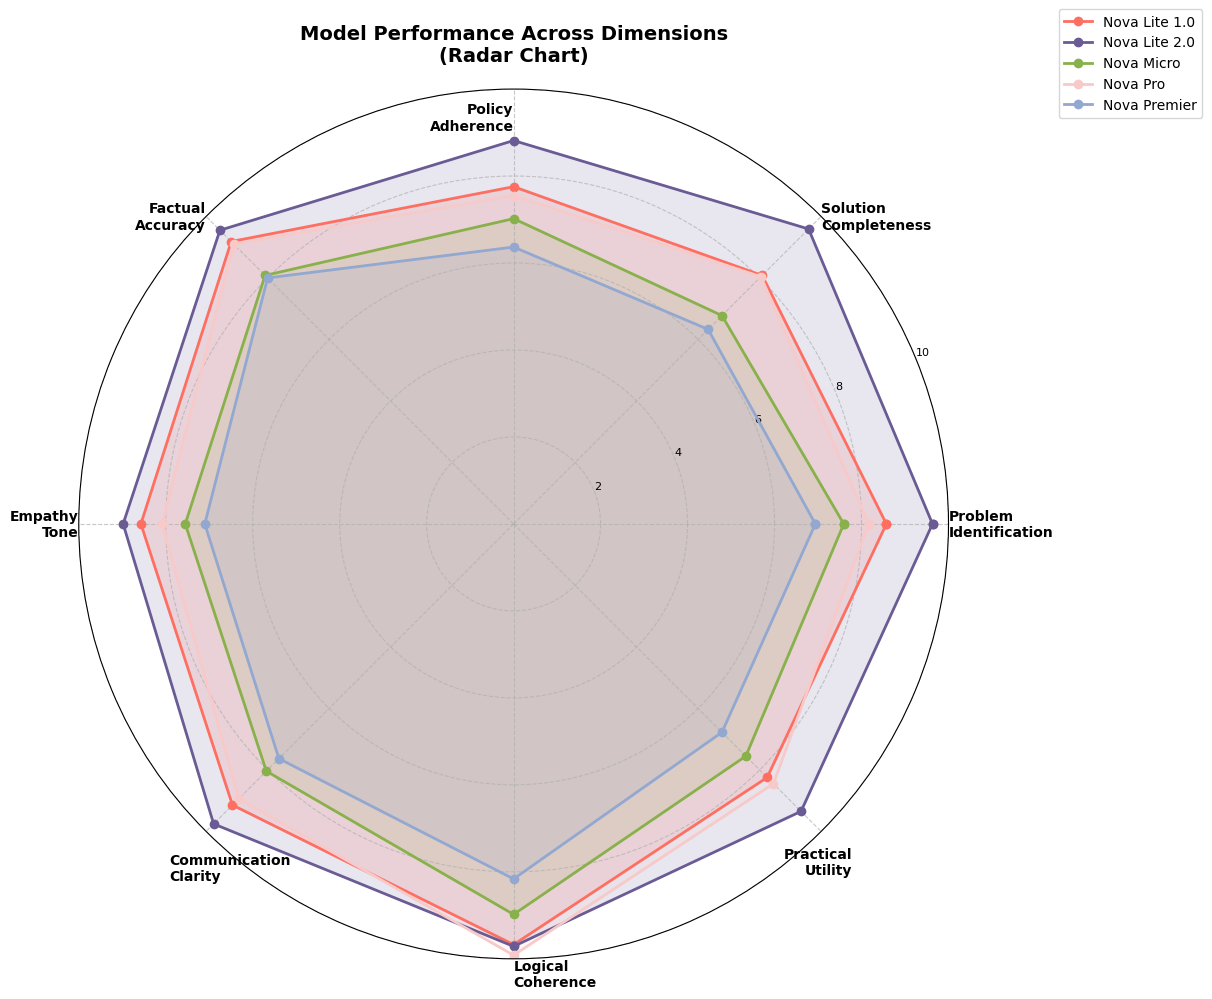

✓ Radar chart saved as 'nova_5_models_radar_chart.png'


In [39]:
# ============================================================================
# RADAR CHART COMPARISON WITH CONFIDENCE INTERVALS
# ============================================================================

print('\nGenerating radar chart with confidence interval shading...')
create_radar_chart_with_ci(df, MODELS_TO_TEST, MODEL_NAMES, dimensions)


## Evaluation Approach Summary

This notebook uses a **categorical-first scoring approach** with fixed score mapping and comprehensive statistical analysis.

### Scoring System

| Category | Fixed Score | Meaning |
|----------|-------------|----------|
| **EXCELLENT** | 10 | Comprehensive, professional, exceeds expectations |
| **GOOD** | 8 | Solid performance with minor room for improvement |
| **ADEQUATE** | 6 | Meets basic requirements but has notable gaps |
| **POOR** | 4 | Significant issues requiring major improvements |
| **FAILING** | 2 | Critical failures, does not meet requirements |

### Statistical Rigor

Following "Adding Error Bars to Evals" (Evan Miller, Anthropic, 2024):
- **Standard errors** and **95% confidence intervals** for all estimates
- **Paired differences analysis** for model comparisons (30-50% variance reduction)
- **Power analysis** to justify sample size (MDE calculation)
- **CV-based consistency** metric (normalized, 0-100 scale)

### Consistency Metrics

**CV-Based (Primary):**
```
CV = (std_dev / mean) × 100%
Consistency = 100 × (1 - CV/100)
```
- 95-100: Excellent (CV < 5%)
- 90-95: Good (CV 5-10%)
- 85-90: Moderate (CV 10-15%)
- < 85: Needs attention (CV > 15%)

This approach ensures fair, consistent, and statistically rigorous model comparisons.


Generating comparison bar chart with 95% confidence interval error bars...


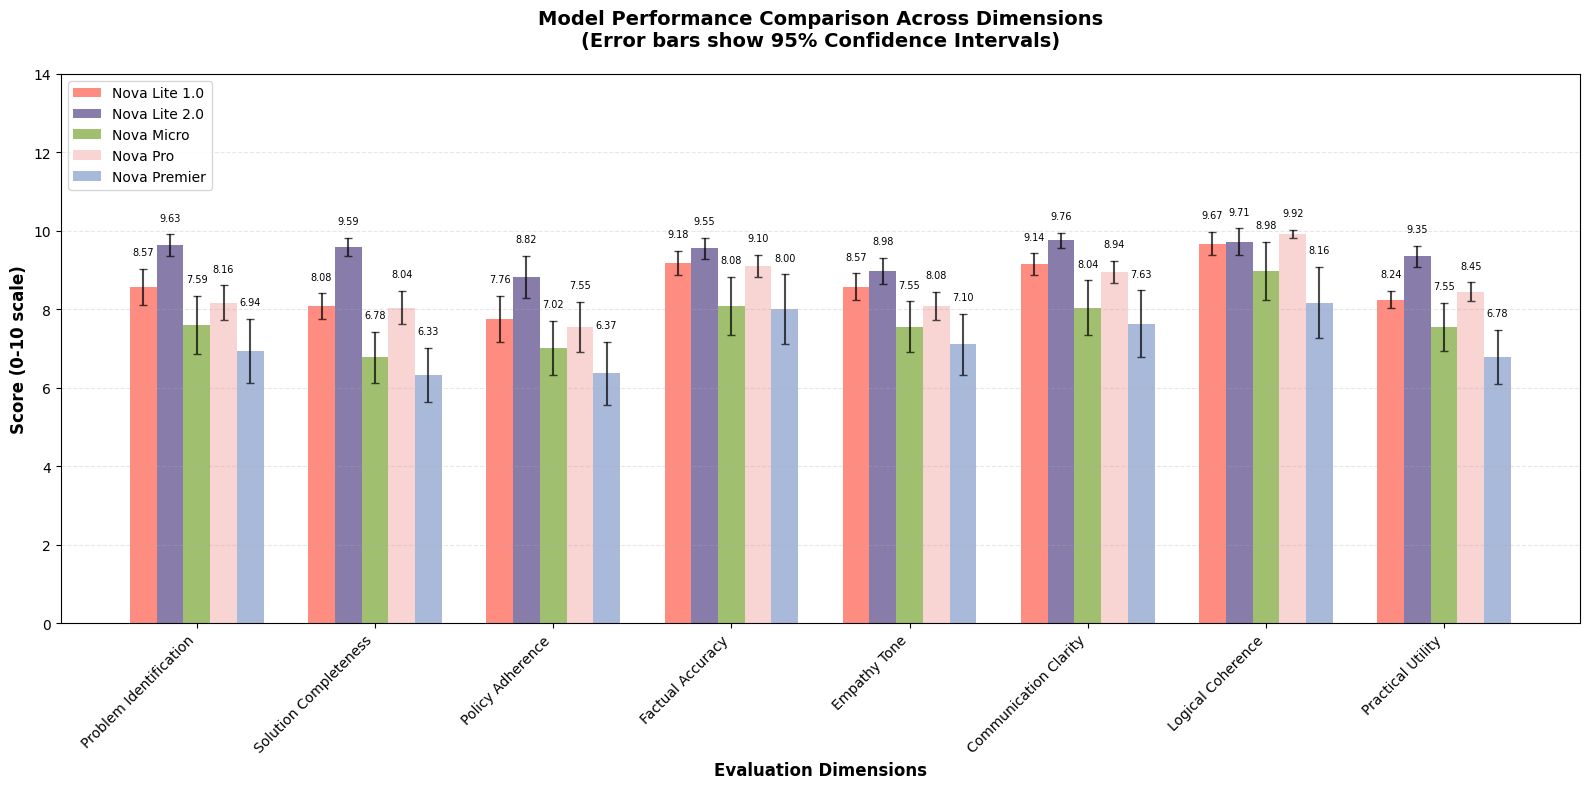

✓ Comparison chart saved as 'nova_5_models_comparison_chart.png'


In [12]:
# ============================================================================
# VISUALIZATION: COMPARISON BAR CHART WITH ERROR BARS
# ============================================================================

print('\nGenerating comparison bar chart with 95% confidence interval error bars...')
create_comparison_chart_with_error_bars(df, MODELS_TO_TEST, MODEL_NAMES, dimensions)

## Summary: Key Findings and Statistics

This cell provides a concise summary of the evaluation results, highlighting the most important findings and statistics. It's designed to give you the "bottom line" without needing to analyze all the detailed data.

**What's included:**
- **Best performing model overall**: Which model achieved the highest average score
- **Dimension-specific leaders**: Which models excel in specific areas
- **Performance consistency**: Which models have the most stable performance (lowest std dev)
- **Key insights**: Notable patterns or surprising findings

**Why this matters:**
- Provides actionable conclusions from the evaluation
- Helps with quick decision-making
- Identifies clear winners and trade-offs
- Summarizes hours of evaluation in a few key points

This summary is perfect for:
- Executive briefings
- Quick reference during model selection
- Starting point for deeper analysis
- Communicating results to non-technical stakeholders

The goal is to answer the question: "Which model should I use and why?"

In [22]:
# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print('\
' + '='*70)
print('OVERALL MODEL RANKING')
print('='*70)

# Calculate overall rankings (excluding failed evaluations)
model_rankings = []
for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES[model_id]
    model_df = df[df['model_id'] == model_id]
    
    # Exclude failed evaluations (score = 0) from mean and std
    successful_scores = model_df[model_df['overall'] > 0]['overall']
    overall_score = successful_scores.mean() if len(successful_scores) > 0 else 0
    std_dev = successful_scores.std() if len(successful_scores) > 0 else 0
    
    # Calculate consistency scores (both old and new)
    consistency_legacy = 10 / (1 + std_dev) if std_dev > 0 else 10.0
    consistency_cv_result = calculate_consistency_score_cv(successful_scores.values)
    consistency = consistency_cv_result['consistency_score']
    cv_percent = consistency_cv_result['cv']
    
    model_rankings.append({
        'model': model_name,
        'score': overall_score,
        'std': std_dev,
        'consistency': consistency,
            'consistency_legacy': consistency_legacy,
            'cv_percent': cv_percent
    })

# Sort by score
model_rankings.sort(key=lambda x: x['score'], reverse=True)

print('\
Ranking by Overall Performance:')
for i, model in enumerate(model_rankings, 1):
    print(f'{i}. {model["model"]:20s}: {model["score"]:.2f}/10 (±{model["std"]:.2f}) | Consistency: {model["consistency"]:.2f}/100 (CV: {model["cv_percent"]:.2f}%)')

print('\
' + '='*70)
print('COMPARISON COMPLETE!')
print('='*70)

OVERALL MODEL RANKING
Ranking by Overall Performance:
1. Nova Lite 2.0       : 9.42/10 (±0.53) | Consistency: 6.54/10
2. Nova Lite 1.0       : 8.65/10 (±0.61) | Consistency: 6.22/10
3. Nova Pro            : 8.53/10 (±0.82) | Consistency: 5.49/10
4. Nova Micro          : 7.70/10 (±2.23) | Consistency: 3.10/10
5. Nova Premier        : 7.16/10 (±2.68) | Consistency: 2.72/10
COMPARISON COMPLETE!


## Explainability: Understanding the "Why" Behind Scores

This cell demonstrates the enhanced explainability feature by showing detailed reasoning for each dimension score. This transparency is crucial for:

**Trust and validation:**
- Understand why a model received a particular score
- Verify that the evaluator is assessing responses correctly
- Identify specific strengths and weaknesses in responses

**Improvement insights:**
- Learn what makes a response score high or low
- Identify patterns in successful responses
- Guide model fine-tuning or prompt engineering efforts

**Example output format:**
For each dimension (e.g., Problem Identification: 8/10), you'll see:
- The numerical score
- Detailed reasoning explaining what was done well
- Specific examples of what was missing or could be improved

This level of detail transforms the evaluation from a "black box" into a transparent, educational tool. It's particularly valuable for understanding subtle differences between models and for improving your own customer support practices based on what high-scoring responses do well.

In [23]:

# ============================================================================
# EXPLAINABILITY: DETAILED EVALUATION REASONING
# ============================================================================

print('\
' + '='*70)
print('EXPLAINABILITY: SAMPLE EVALUATION REASONING')
print('='*70)

# Show detailed reasoning for a few sample evaluations from each model
dimensions = ['problem_identification', 'solution_completeness', 'policy_adherence',
              'factual_accuracy', 'empathy_tone', 'communication_clarity',
              'logical_coherence', 'practical_utility']

for model_id in MODELS_TO_TEST:
    model_name = MODEL_NAMES.get(model_id, model_id)
    model_df = df[df['model_id'] == model_id]
    
    # Get one successful evaluation (highest scoring)
    successful = model_df[model_df['overall'] > 0].sort_values('overall', ascending=False)
    
    if len(successful) > 0:
        sample = successful.iloc[0]
        
        print(f'{"="*70}')
        print(f'{model_name} - Sample Evaluation')
        print(f'{"="*70}')
        print(f'Scenario: {sample["scenario_name"]}')
        print(f'Run: {sample["run"]}')
        print(f'Overall Score: {sample["overall"]:.2f}/10')
        print(f'{"-"*70}')
        print('DIMENSION-BY-DIMENSION REASONING:')
        print(f'{"-"*70}')
        
        for dim in dimensions:
            score = sample[dim]
            reasoning_key = f'{dim}_reasoning'
            reasoning = sample.get(reasoning_key, 'No reasoning provided')
            
            print(f'{dim.replace("_", " ").title()}:')
            print(f'  Score: {score:.1f}/10')
            print(f'  Reasoning: {reasoning}')
            print()
        
        print(f'{"-"*70}')
        print('OVERALL JUSTIFICATION:')
        print(f'{"-"*70}')
        print(sample.get('overall_justification', 'No overall justification provided'))
        print()

print('' + '='*70)
print('Note: Full reasoning for all evaluations is saved in the CSV/JSON output files')

EXPLAINABILITY: SAMPLE EVALUATION REASONING
Nova Lite 1.0 - Sample Evaluation
Scenario: Software Technical Problem
Run: 8
Overall Score: 10.00/10
----------------------------------------------------------------------
DIMENSION-BY-DIMENSION REASONING:
----------------------------------------------------------------------
Problem Identification:
  Score: 10.0/10
  Reasoning: The response explicitly identifies the app crashing during photo upload, the device (iPhone 12) and iOS version (16.1), and acknowledges the customer’s work-related urgency and frustration. It captures all key issues from the customer’s message.

Solution Completeness:
  Score: 10.0/10
  Reasoning: All identified problems are addressed with practical, actionable steps: clearing app cache, updating the app and iOS, checking photo size/format, rebooting, enabling background refresh, resetting network settings, trying a different network, and offering escalation. The solution set is comprehensive.

Policy Adherence:
  S

## Evaluation Approach Summary

This notebook uses a **categorical-first scoring approach** with fixed score mapping and comprehensive statistical analysis.

### Scoring System

| Category | Fixed Score | Meaning |
|----------|-------------|----------|
| **EXCELLENT** | 10 | Comprehensive, professional, exceeds expectations |
| **GOOD** | 8 | Solid performance with minor room for improvement |
| **ADEQUATE** | 6 | Meets basic requirements but has notable gaps |
| **POOR** | 4 | Significant issues requiring major improvements |
| **FAILING** | 2 | Critical failures, does not meet requirements |

### Why This Approach?

**Research-backed benefits:**
- ✅ More consistent evaluations (discrete categories reduce ambiguity)
- ✅ Better interpretability (semantic labels are clearer than numbers)
- ✅ Reduced evaluator bias (clear decision boundaries)
- ✅ Simpler validation (one category = one score)

**Evaluation process:**
1. Evaluator (GPT OSS 20B) reads the model response
2. Assigns a category label for each of 8 dimensions
3. Fixed score is automatically determined by category
4. Provides detailed reasoning for the categorization

### Statistical Rigor

Following "Adding Error Bars to Evals" (Evan Miller, Anthropic, 2024):
- **Standard errors** and **95% confidence intervals** for all estimates
- **Paired differences analysis** for model comparisons (30-50% variance reduction)
- **Power analysis** to justify sample size (MDE calculation)
- **CV-based consistency** metric (normalized, 0-100 scale)

### Consistency Metrics

**CV-Based (Primary):**
```
CV = (std_dev / mean) × 100%
Consistency = 100 × (1 - CV/100)
```

**Interpretation:**
- **95-100**: Excellent consistency (CV < 5%)
- **90-95**: Good consistency (CV 5-10%)
- **85-90**: Moderate consistency (CV 10-15%)
- **< 85**: Needs attention (CV > 15%)

**Why CV-based?**
- ✅ Normalized by mean (fair comparison across different score ranges)
- ✅ Standard statistical measure (Coefficient of Variation)
- ✅ Clear interpretation (percentage-based, 0-100 scale)
- ✅ Industry standard for reliability assessment

This approach ensures fair, consistent, and statistically rigorous model comparisons.